In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import os
import logging

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits, deep_emulator

In [58]:
from agnfinder.prospector import main
from agnfinder.prospector import visualise

In [59]:
os.chdir('/home/walml/repos/agnfinder')

In [60]:
index = 0

In [61]:


# load randomly from cube
# _, _, x_test, y_test = deep_emulator.data(cube_dir=cube_loc)  # TODO apply selection filters
# OR load from preselected test sample
x_test = np.loadtxt('data/cubes/x_test.npy')
y_test = np.loadtxt('data/cubes/y_test.npy')

assert y_test.shape[1] == 8  # euclid cube
cube_photometry = deep_emulator.denormalise_photometry(y_test[index])  # other selection params have no effect
cube_params = x_test[index]  # only need for redshift
# pretend cube is catalog photometry
filters = load_photometry.get_filters('euclid')
galaxy = {}
for n, f in enumerate(filters):
    galaxy[f.maggie_col] = cube_photometry[n]
galaxy['redshift'] = cube_params[0] * 4.  # 4 to scale from hcube. Again, crucial not to change param_lims!
true_theta = cube_params[1:]  # fixed redshift, normalised. Need to denormalise at end, or (better?) normalise samples.
logging.info(f'True theta: {true_theta}')

# estimate_maggie_unc expects a batch dimension, so temporarily add one
maggie_uncertainty = np.squeeze(load_photometry.estimate_maggie_uncertainty(np.expand_dims(cube_photometry, axis=0)))
for n, f in enumerate(filters):
    galaxy[f.maggie_error_col] = maggie_uncertainty[n]



In [62]:
agn_mass = True
agn_eb_v = True
agn_torus_mass = True
igm_absorbtion = True # actually fixed
inclination = True
emulate_ssp = False

In [63]:

redshift = galaxy['redshift']

run_params, obs, model, sps = main.construct_problem(
    galaxy=galaxy,  # now a kwarg that's none by default, as we usually only want the forward model
    redshift=redshift,
    agn_mass=agn_mass,
    agn_eb_v=agn_eb_v,
    agn_torus_mass=agn_torus_mass,
    igm_absorbtion=igm_absorbtion,
    inclination=inclination,
    emulate_ssp=emulate_ssp,
    filter_selection='euclid'
)


In [86]:
theta_best, results, _ = main.fit_galaxy(run_params, obs, model, sps)


In [87]:
results[1]

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0])
        cost: 153824352004.28342
         fun: array([ -70241.31463943, -294062.61629831, -293228.58513962,
       -268047.00350207, -105762.98486968, -115733.84128374,
       -111066.3141998 , -146608.26394136])
        grad: array([ 3.09859843e-01, -2.61767973e+11, -1.52968865e+11,  8.56523806e+09,
       -1.15990545e+29, -2.29204133e+07,  1.46518240e+12, -1.30347455e+07])
         jac: array([[-7.07392212e-08,  1.07247362e+05,  4.68728286e+04,
        -2.76526447e+03,  8.25701859e+22,  1.78832812e+01,
        -5.81094808e+04,  9.06790273e-02],
       [-2.96179858e-07,  3.52079383e+05,  1.66262550e+05,
        -9.11565166e+03,  8.25701859e+22,  3.12470360e+01,
        -3.66610232e+05,  6.13307286e-01],
       [-2.95345146e-07,  2.64179990e+05,  1.44698069e+05,
        -7.96463772e+03,  8.25701859e+22,  2.40589678e+01,
        -9.37648557e+05,  1.78976581e+00],
       [-2.69975138e-07,  1.89331583e+05,  1.23478089e+05,
        -6.93828132e

In [88]:
results[0]['cost']

60807.89217679448

In [89]:
results[0]['x']

array([5.91473861e+09, 1.91791059e+00, 3.03718768e+00, 6.81786257e-01,
       1.00021341e-07, 4.67187783e-01, 2.44260797e-03, 5.78372729e+01])

In [90]:
logging.info(list(zip(model.free_params, theta_best)))
# TODO save best_theta to json?


 /home/walml/repos/agnfinder/agnfinder/prospector/visualise.py:53: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


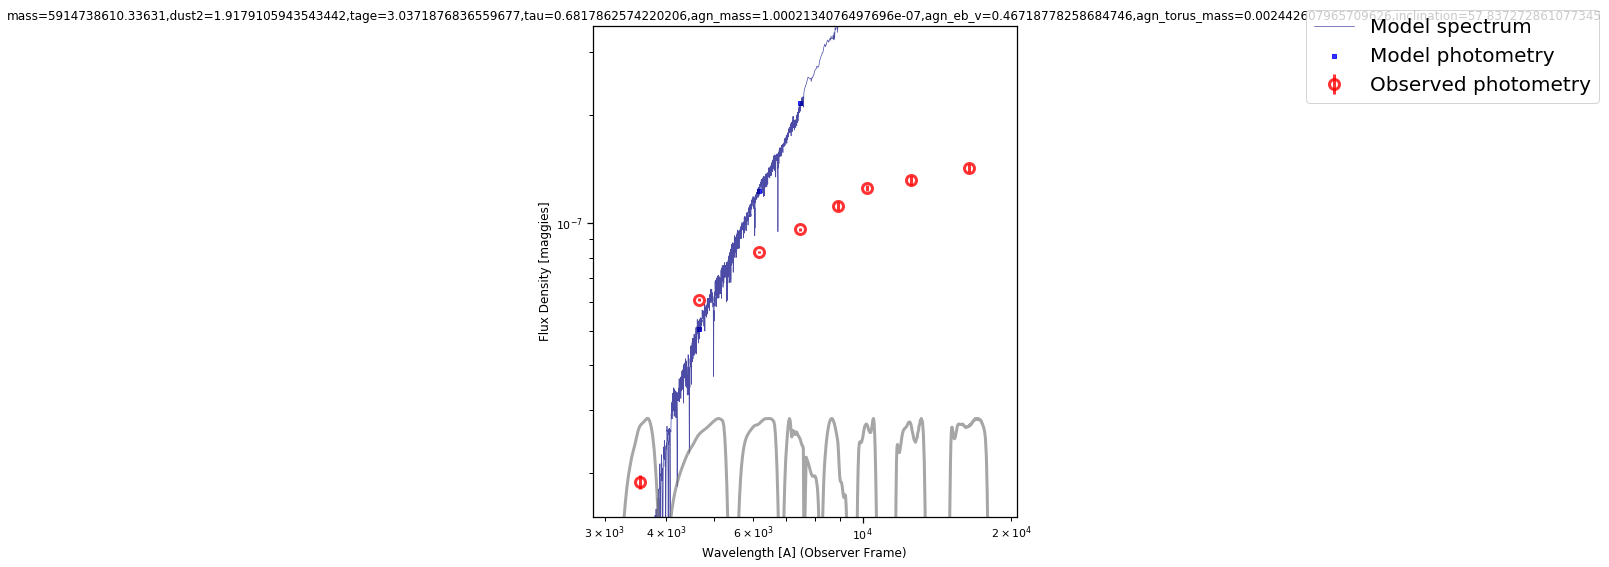

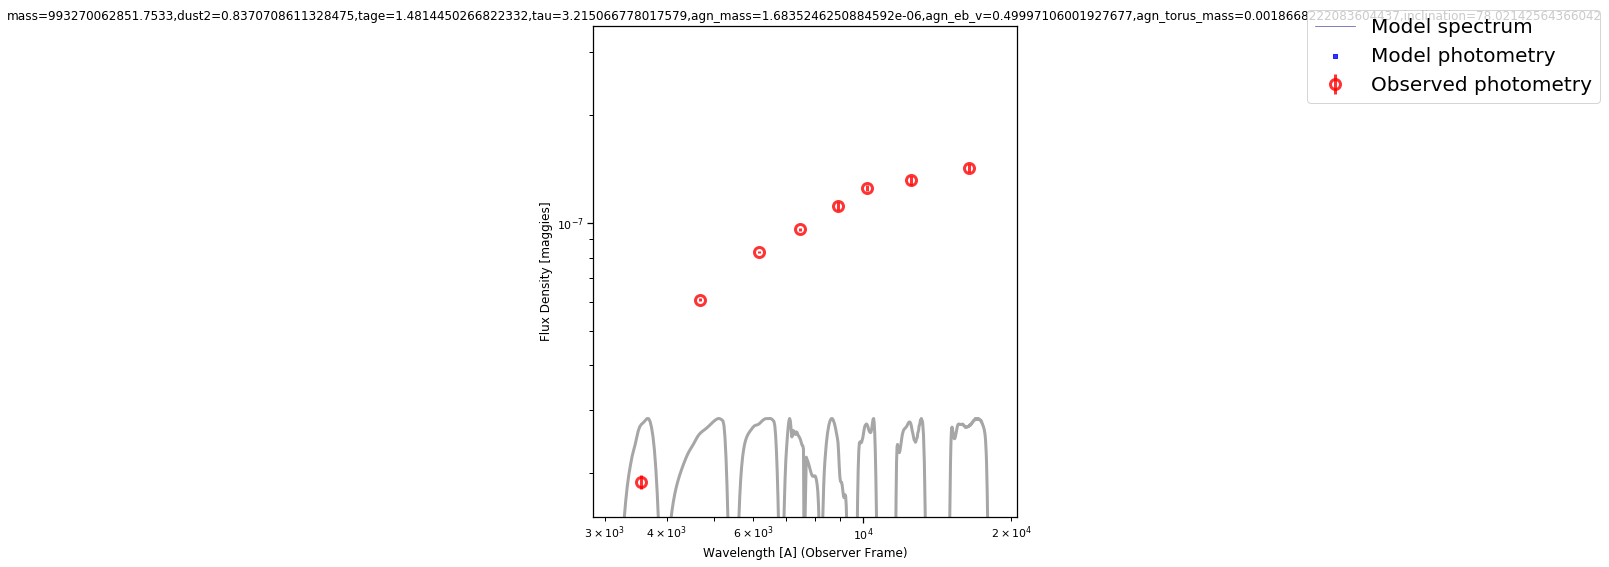

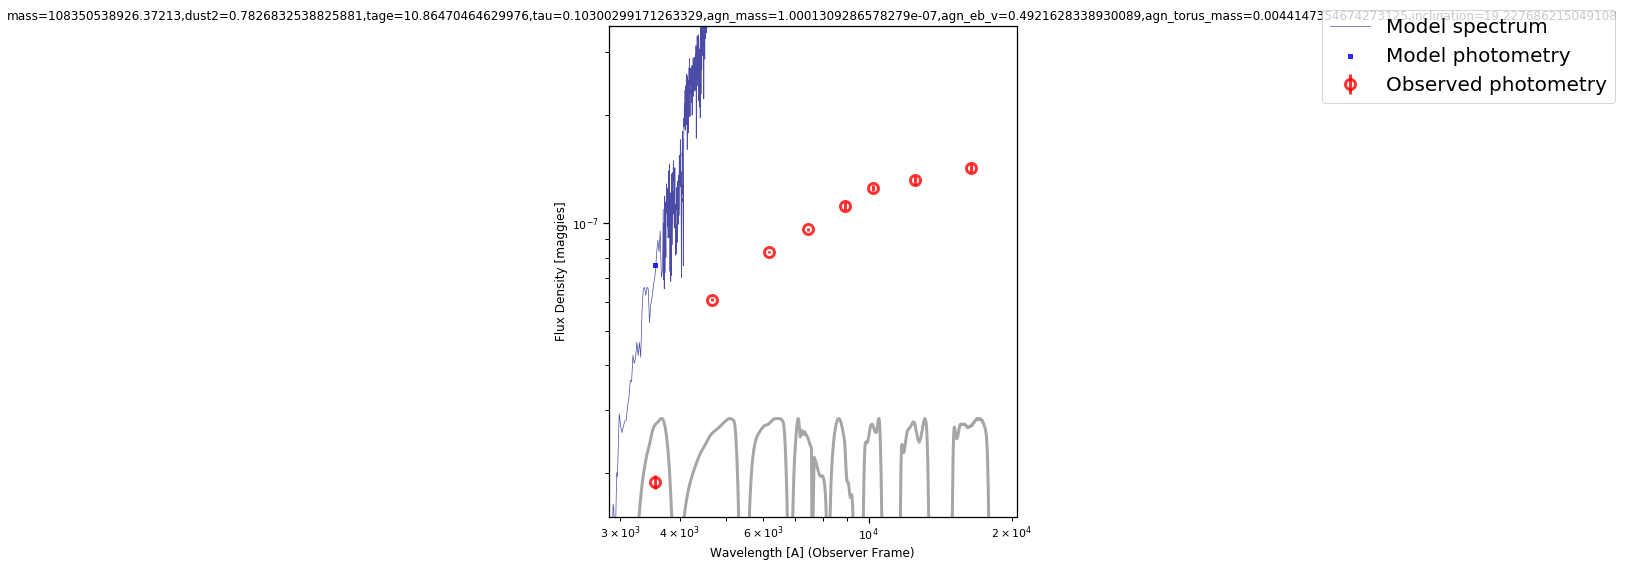

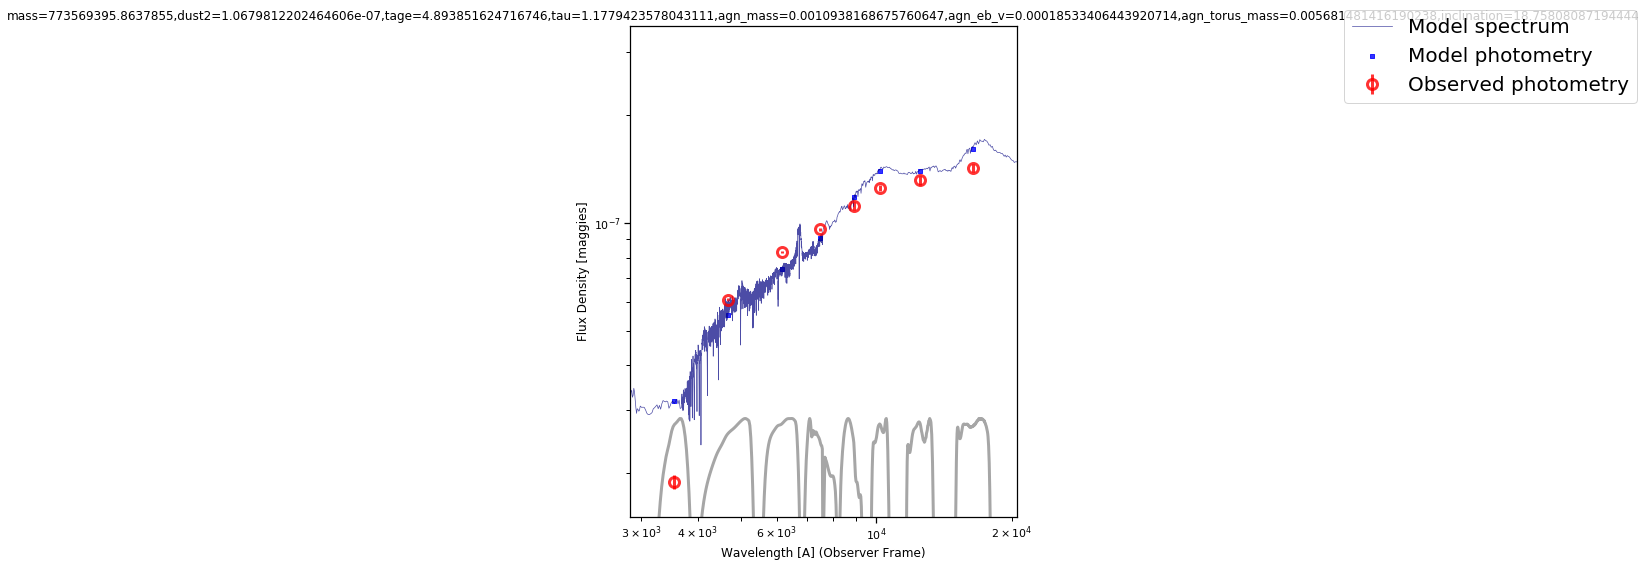

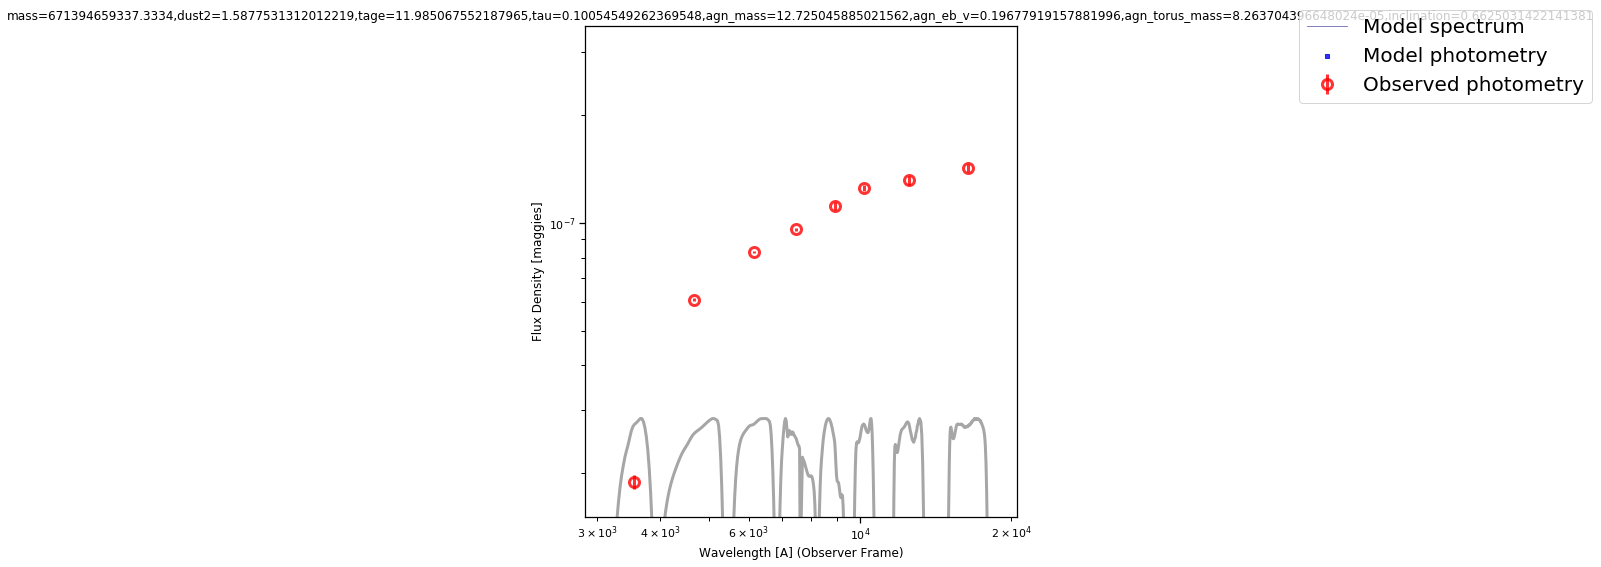

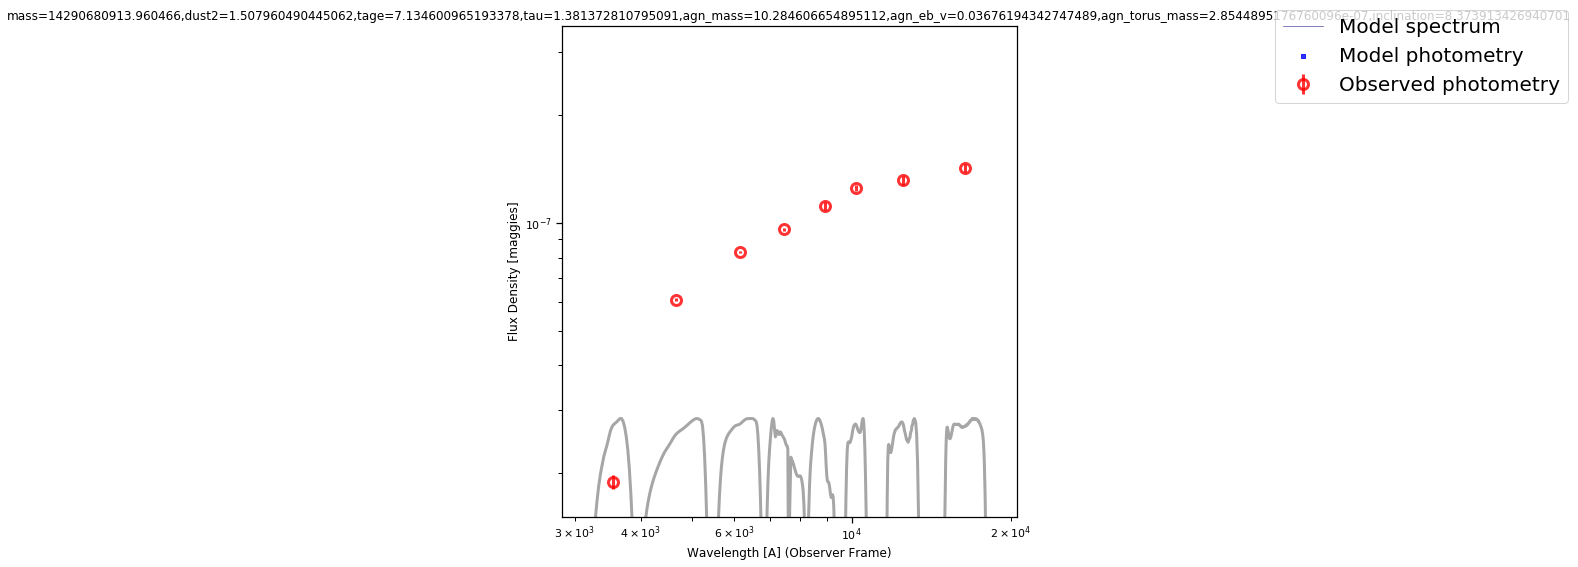

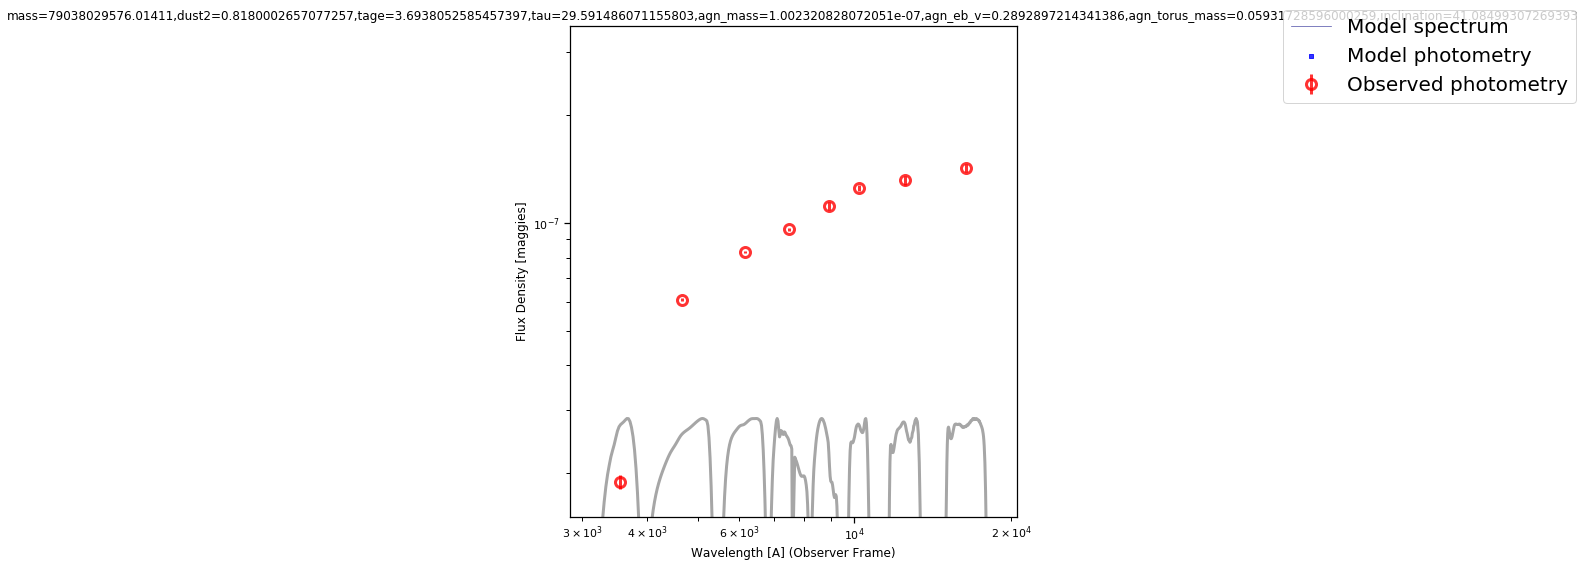

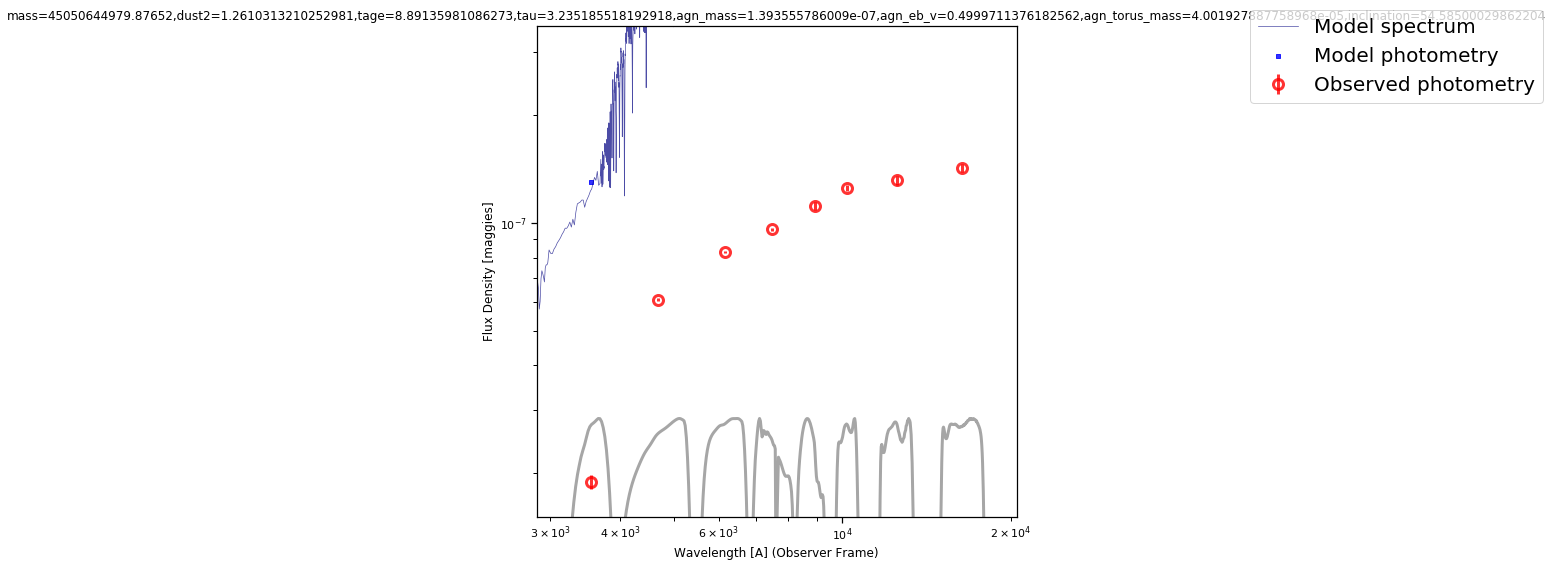

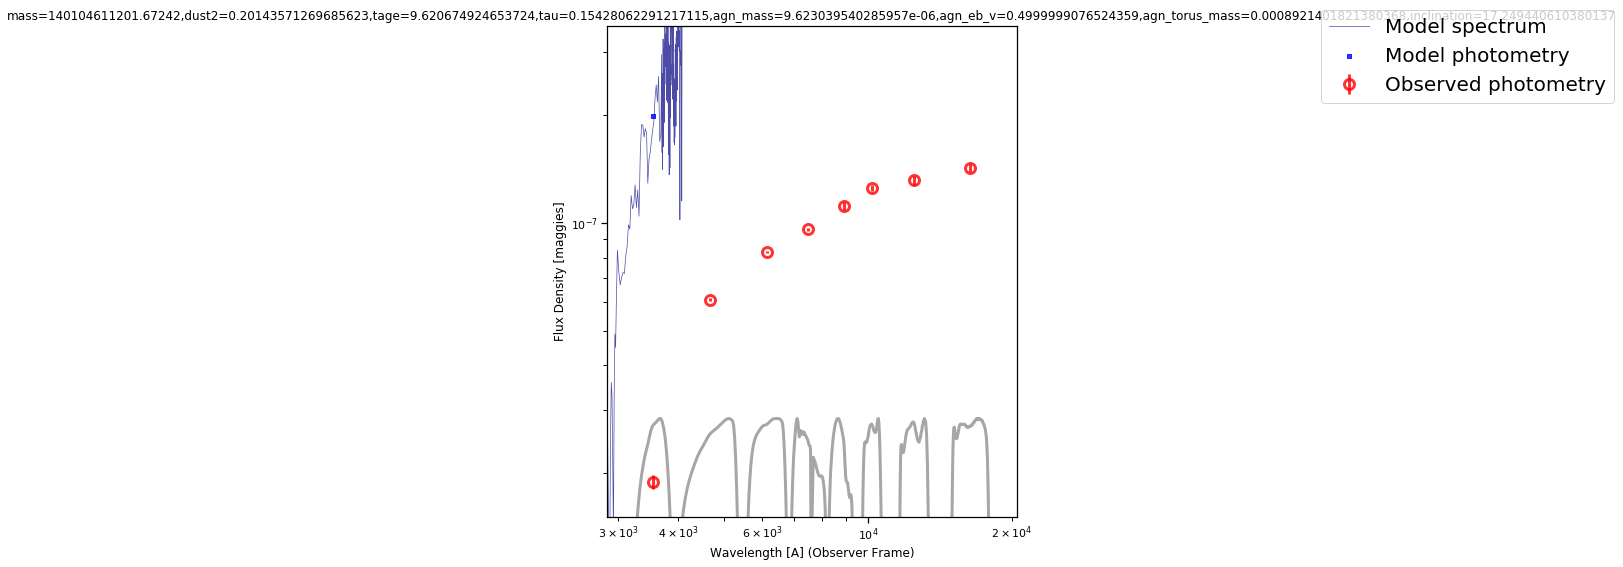

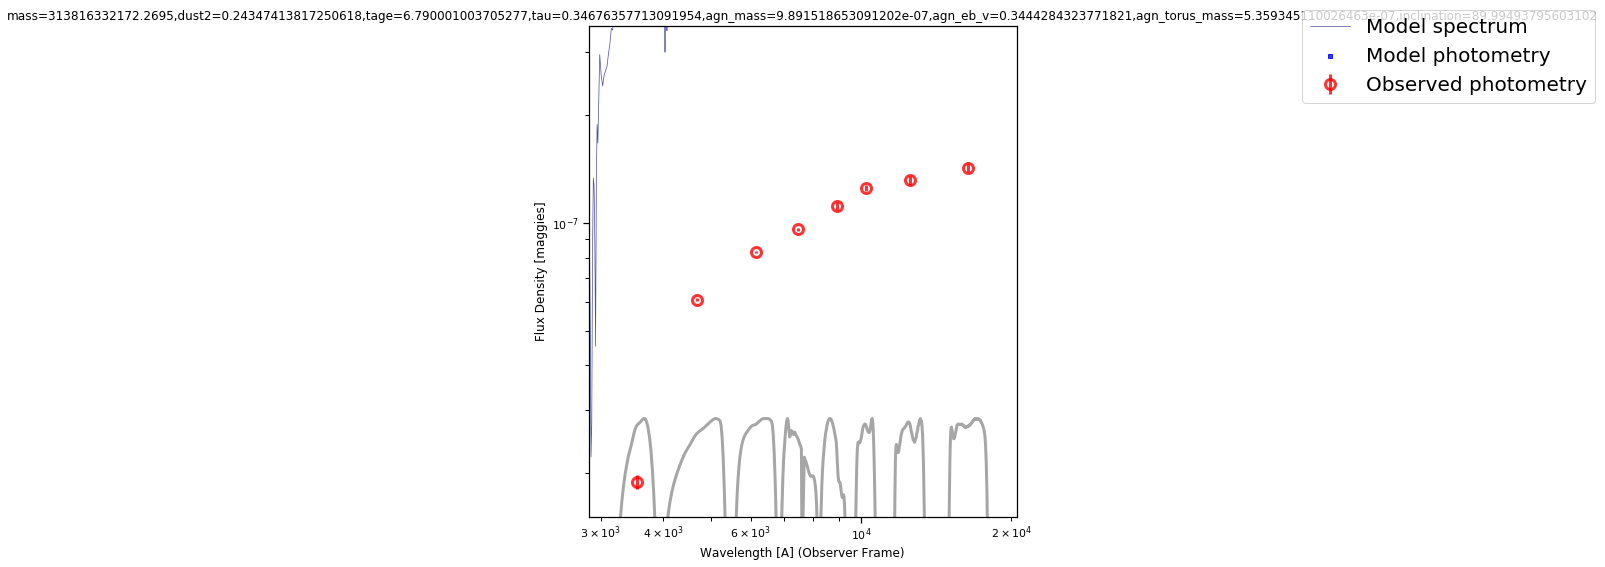

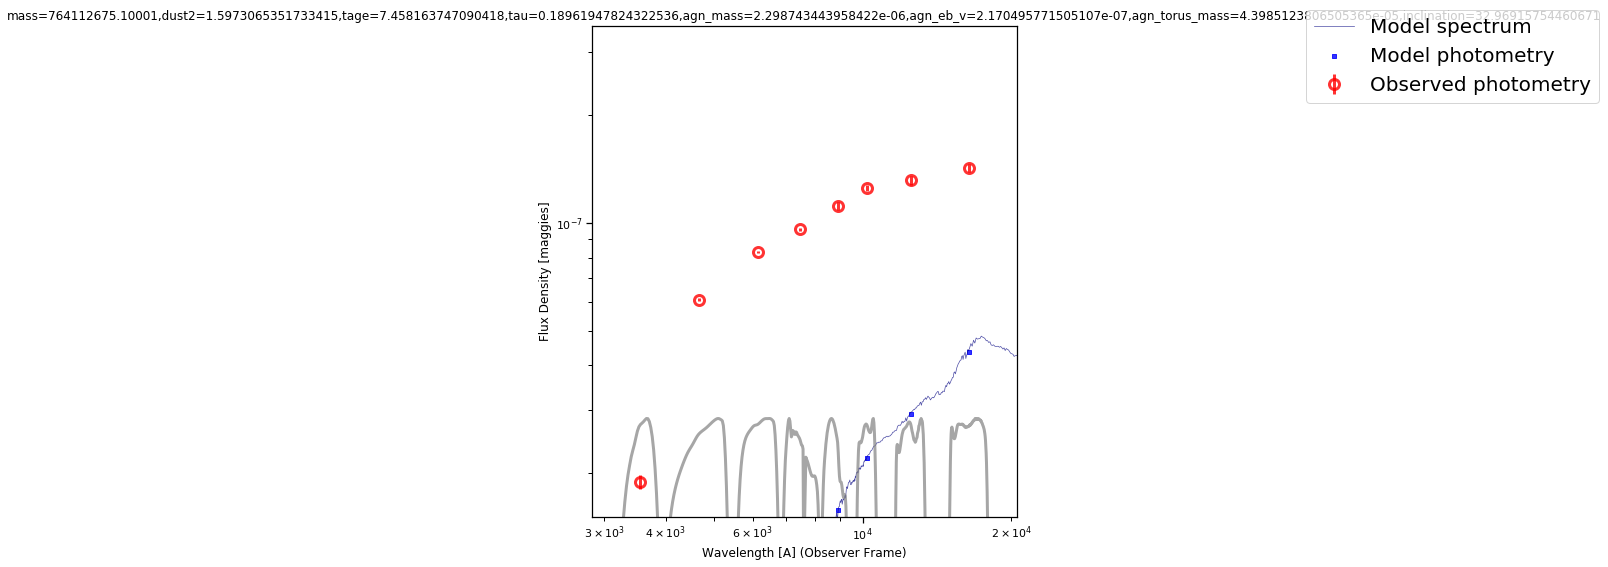

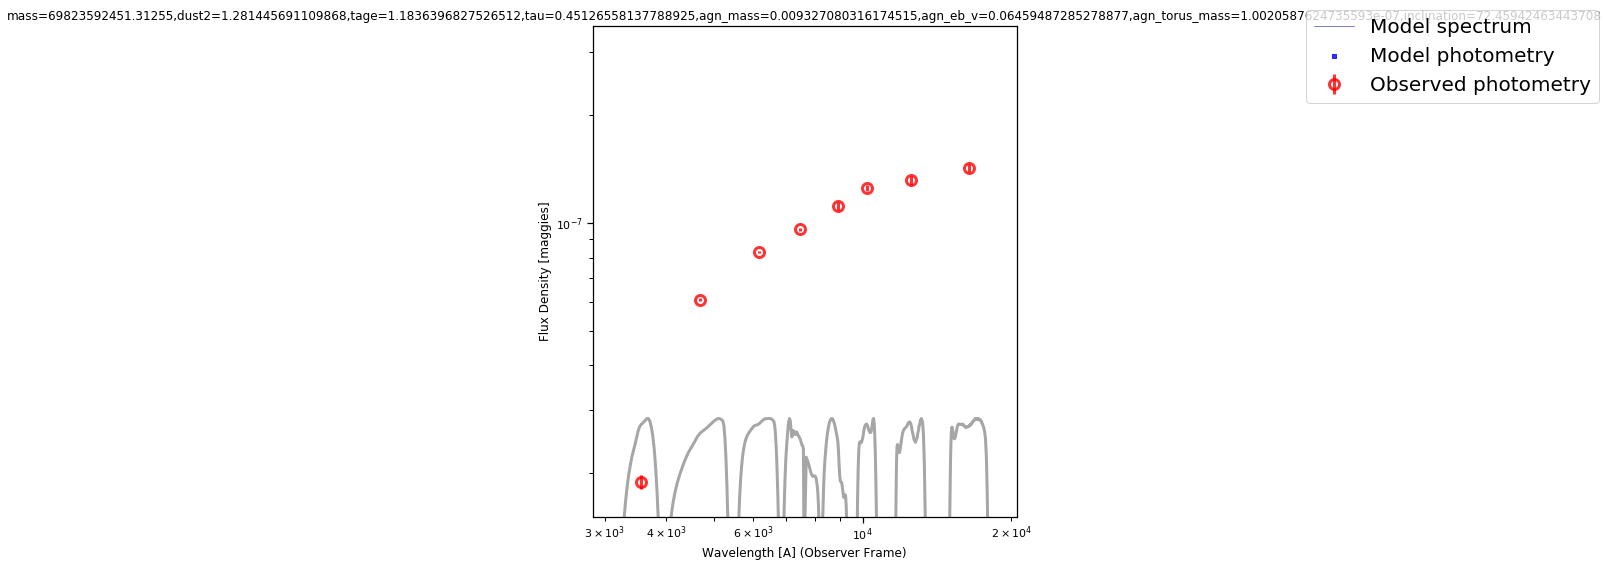

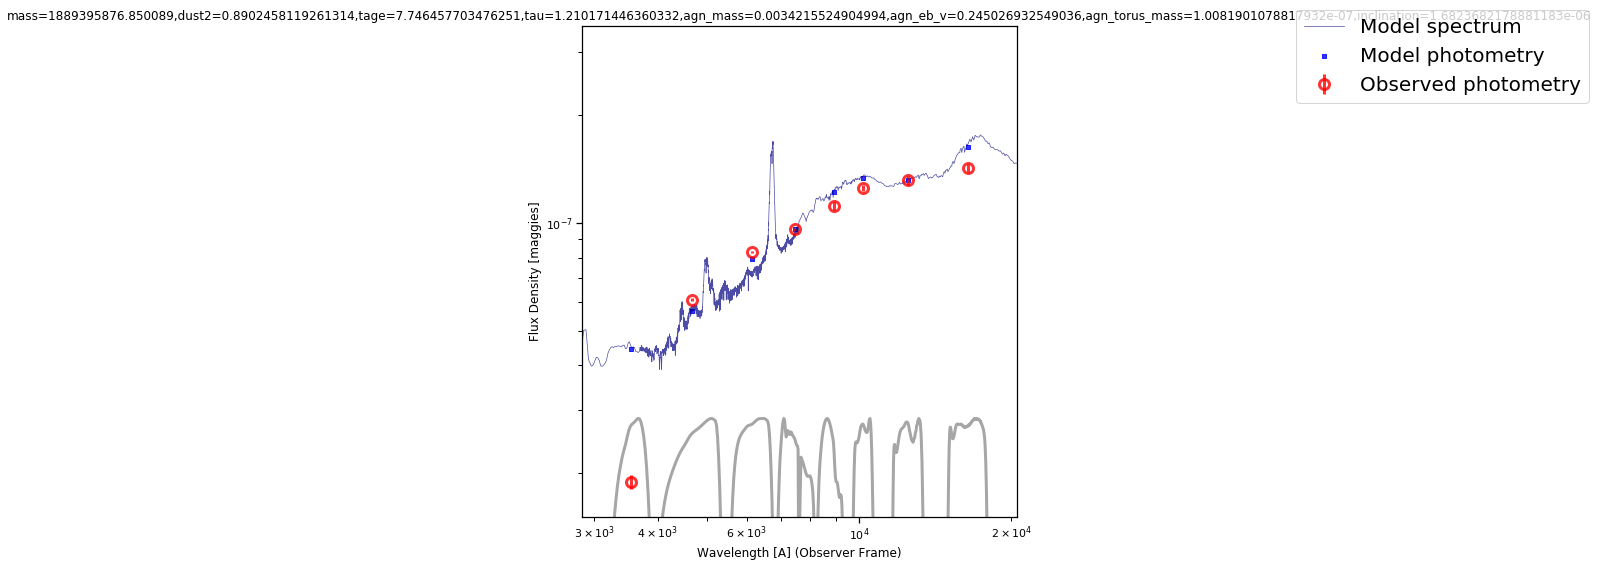

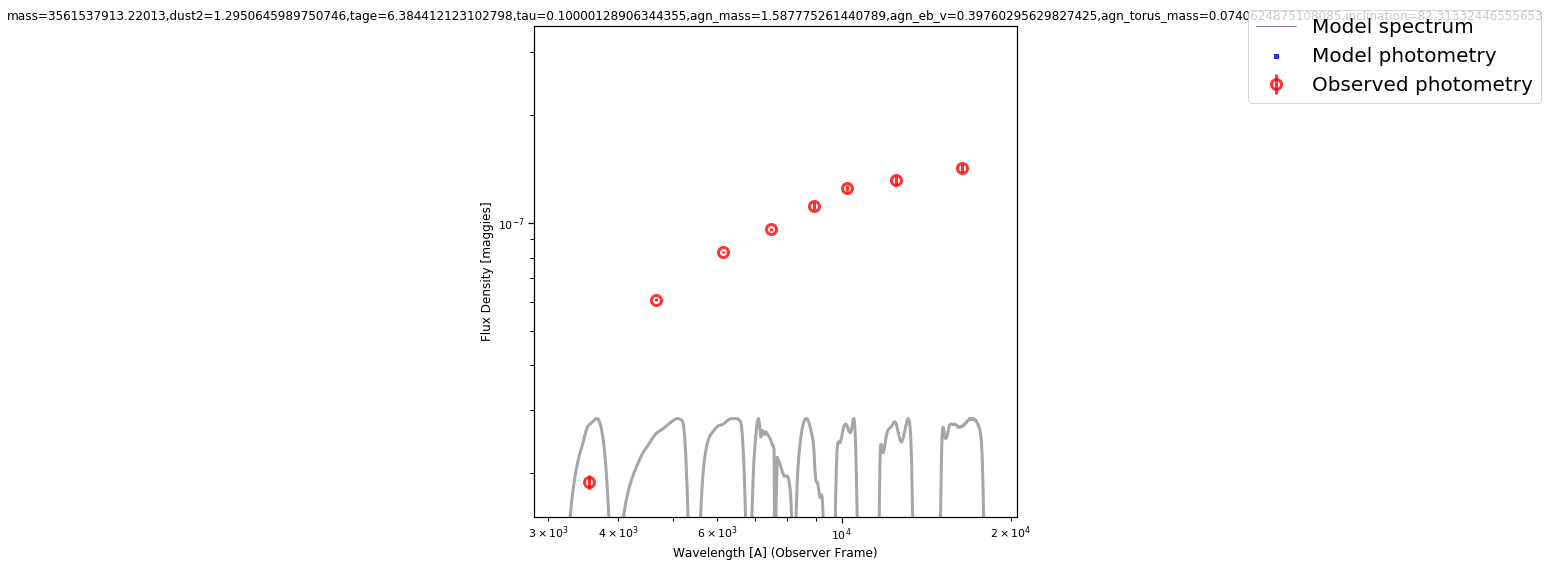

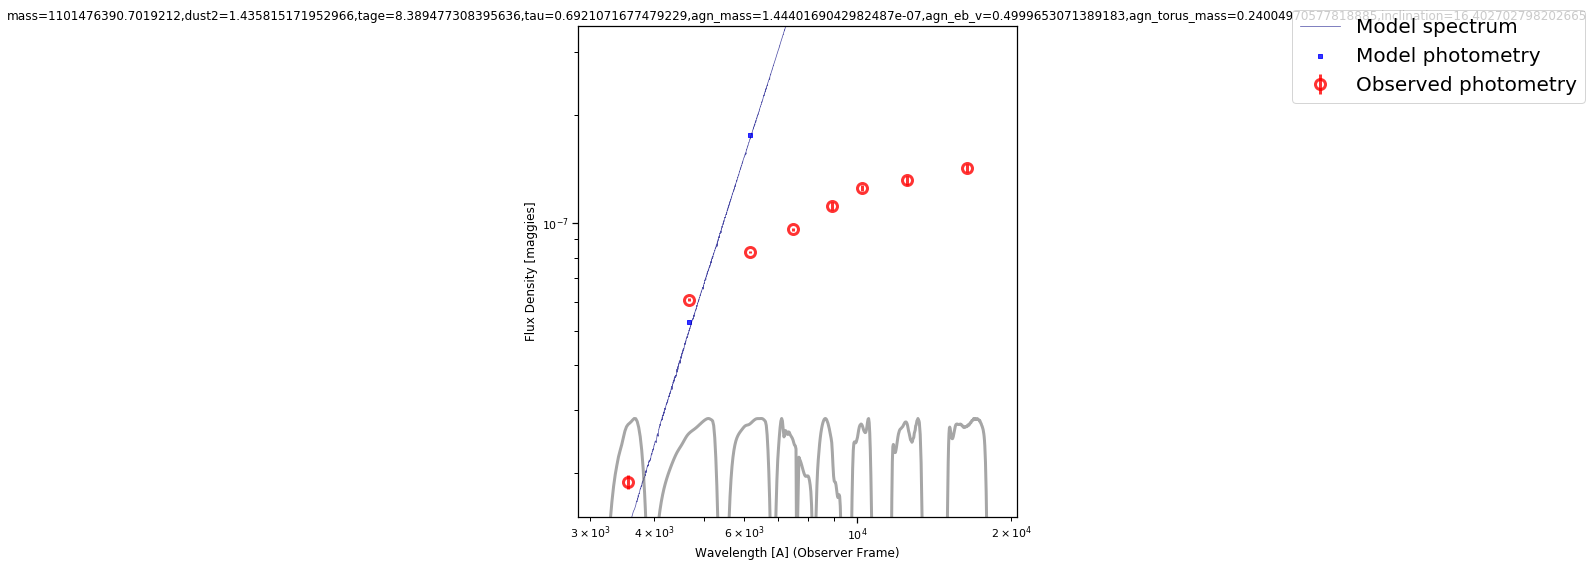

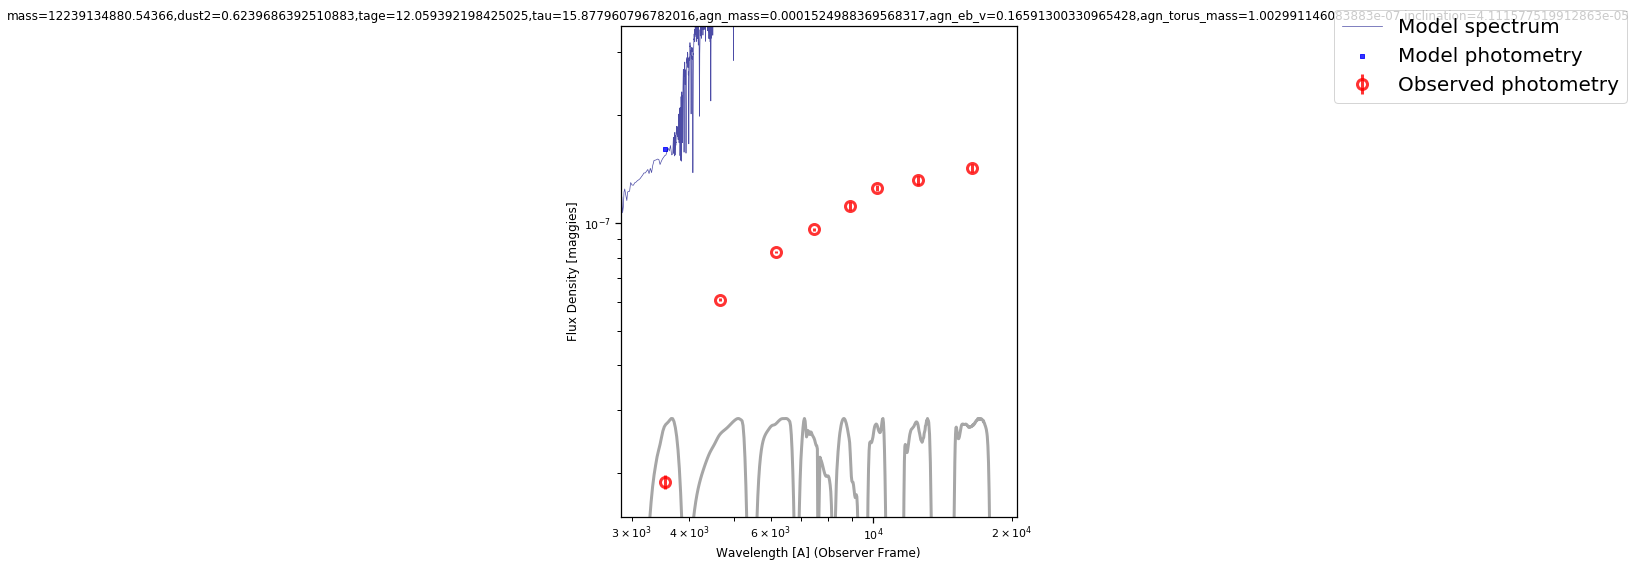

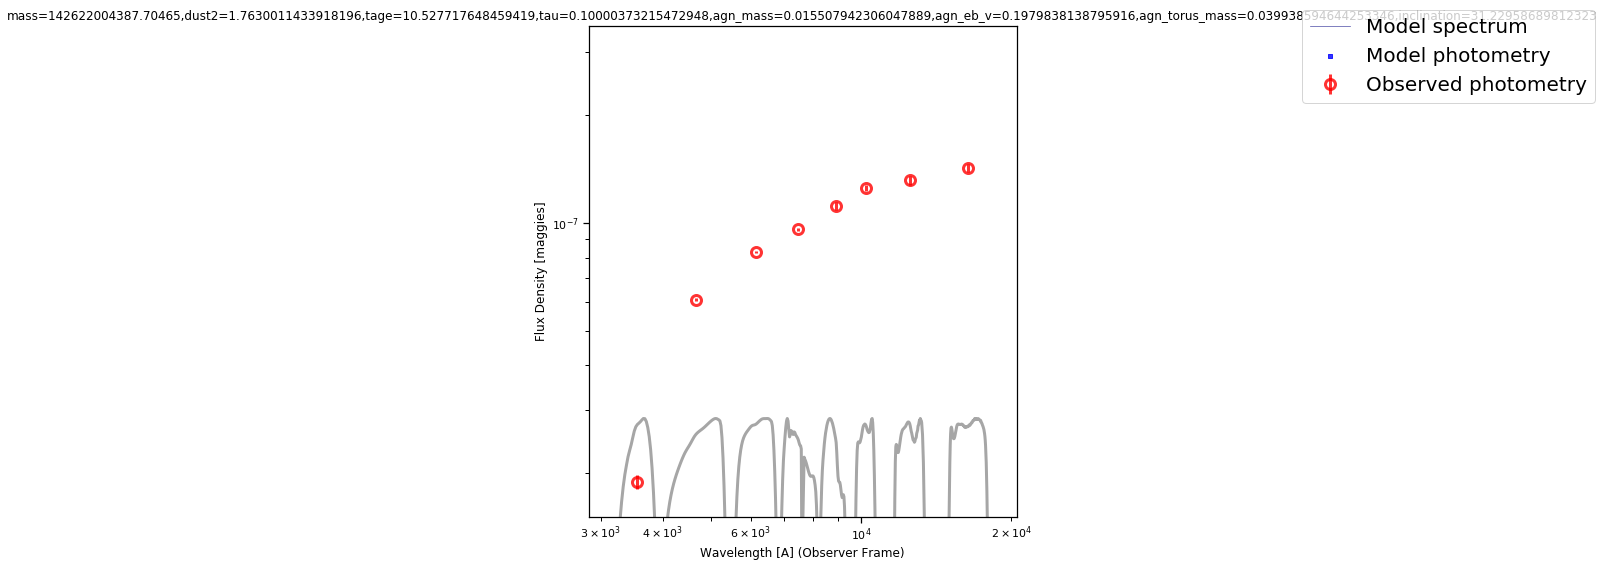

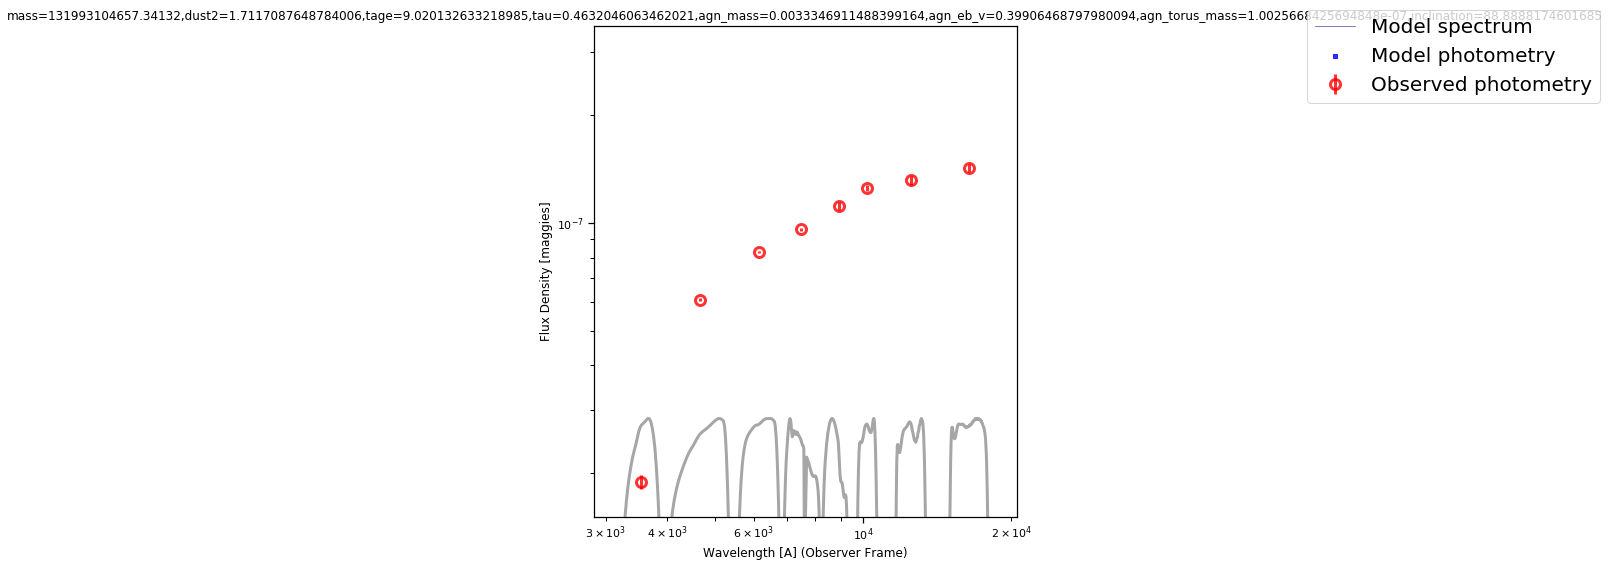

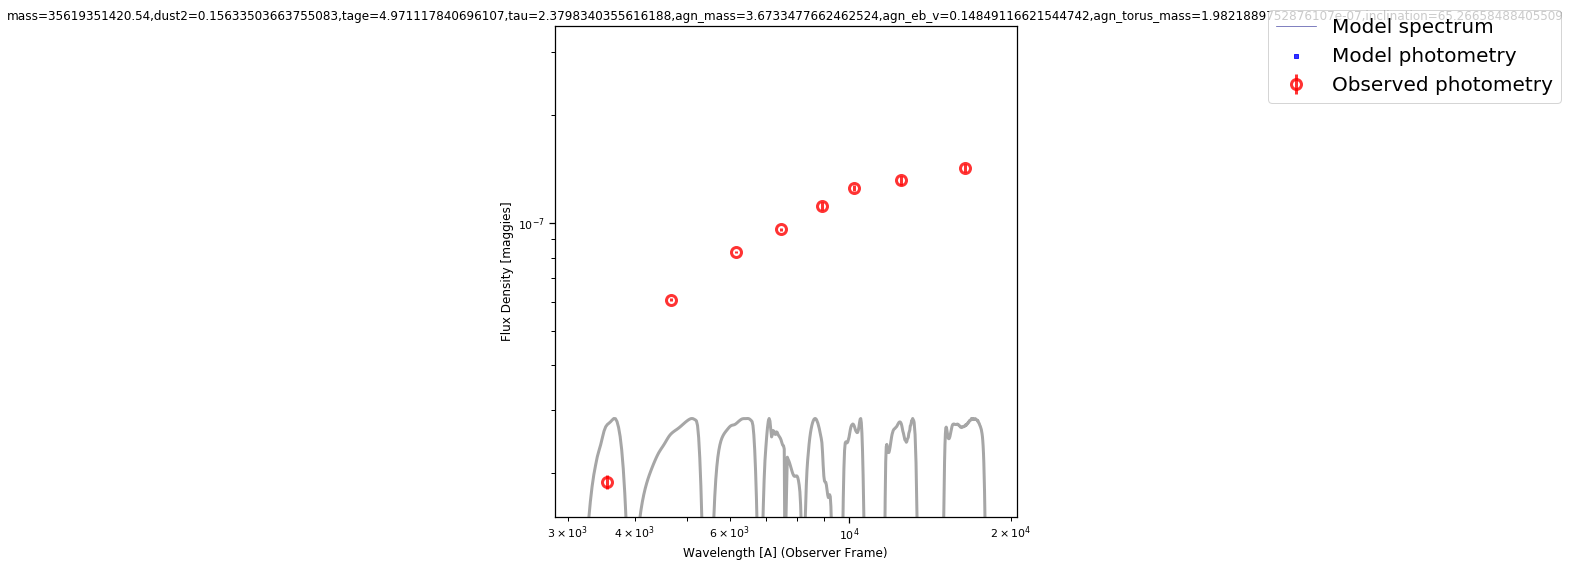

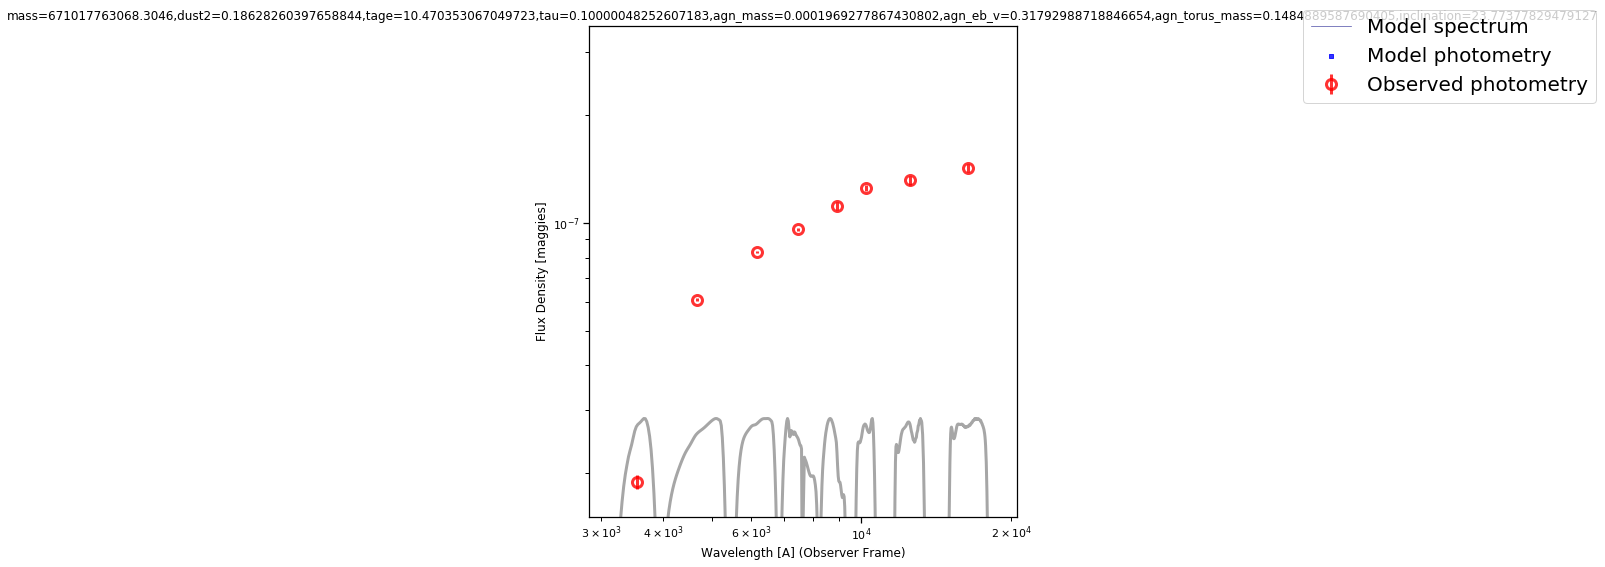

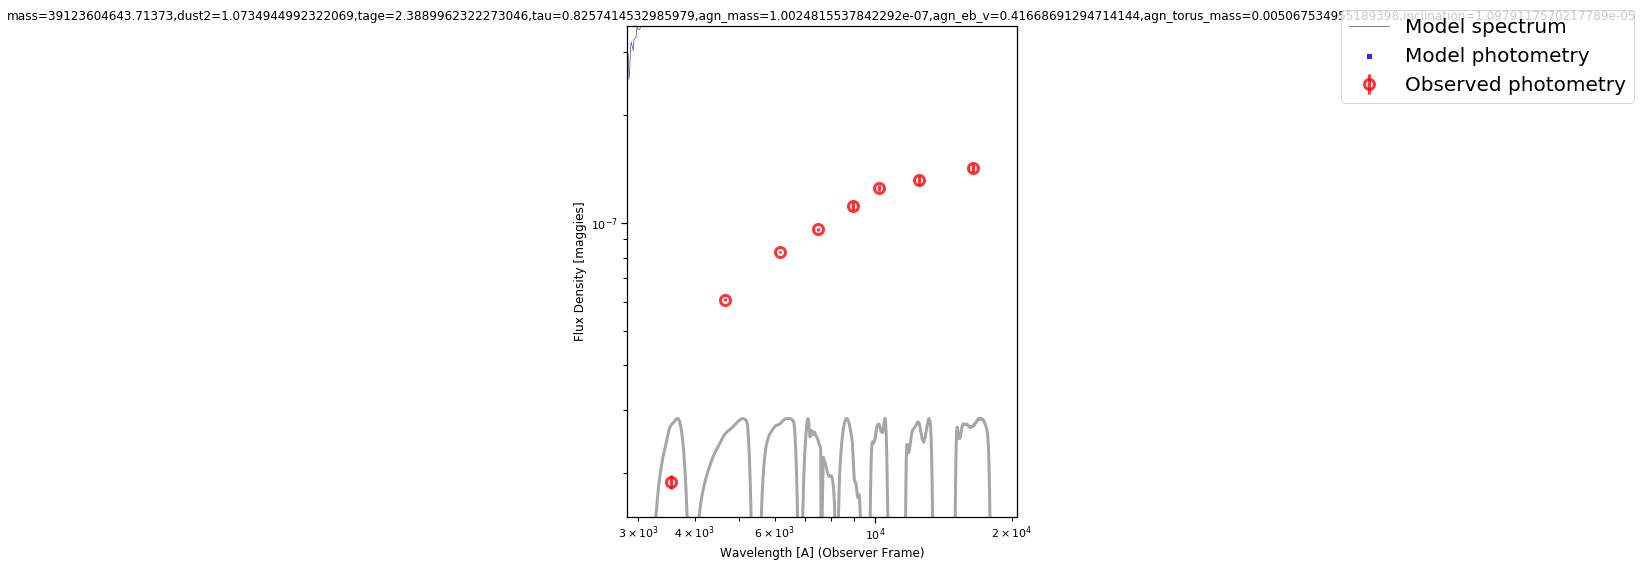

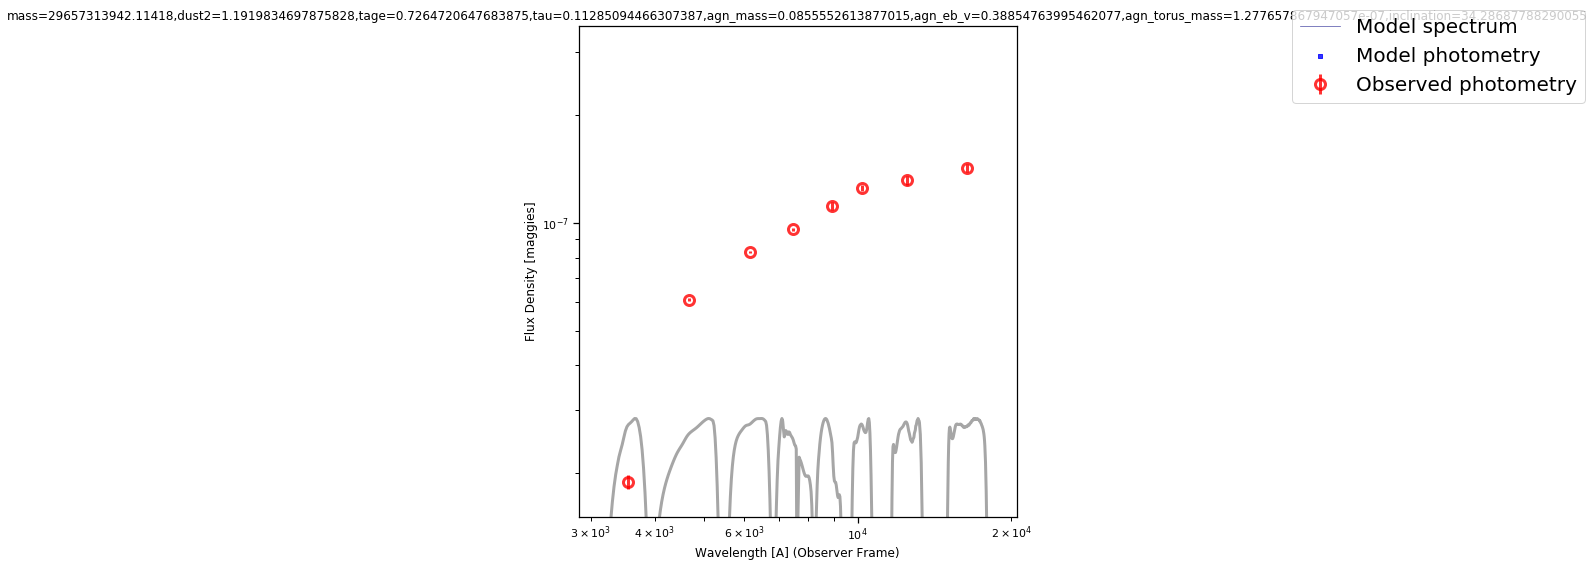

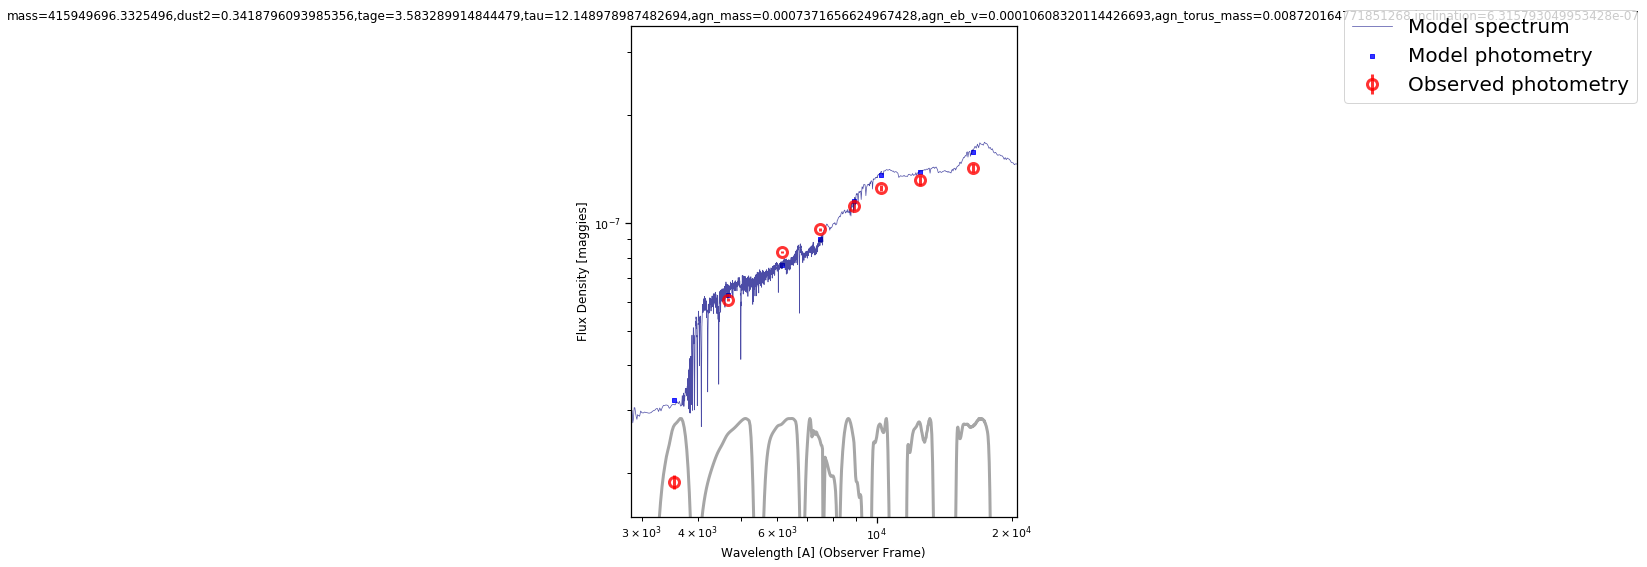

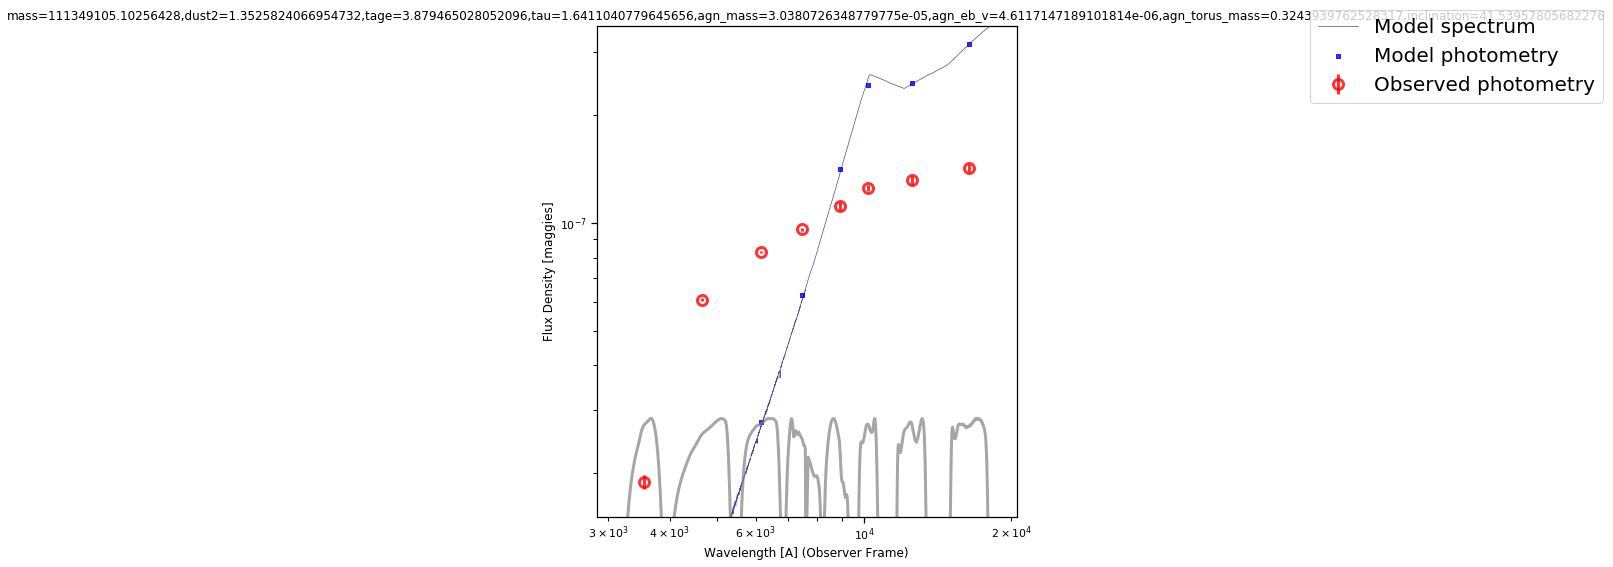

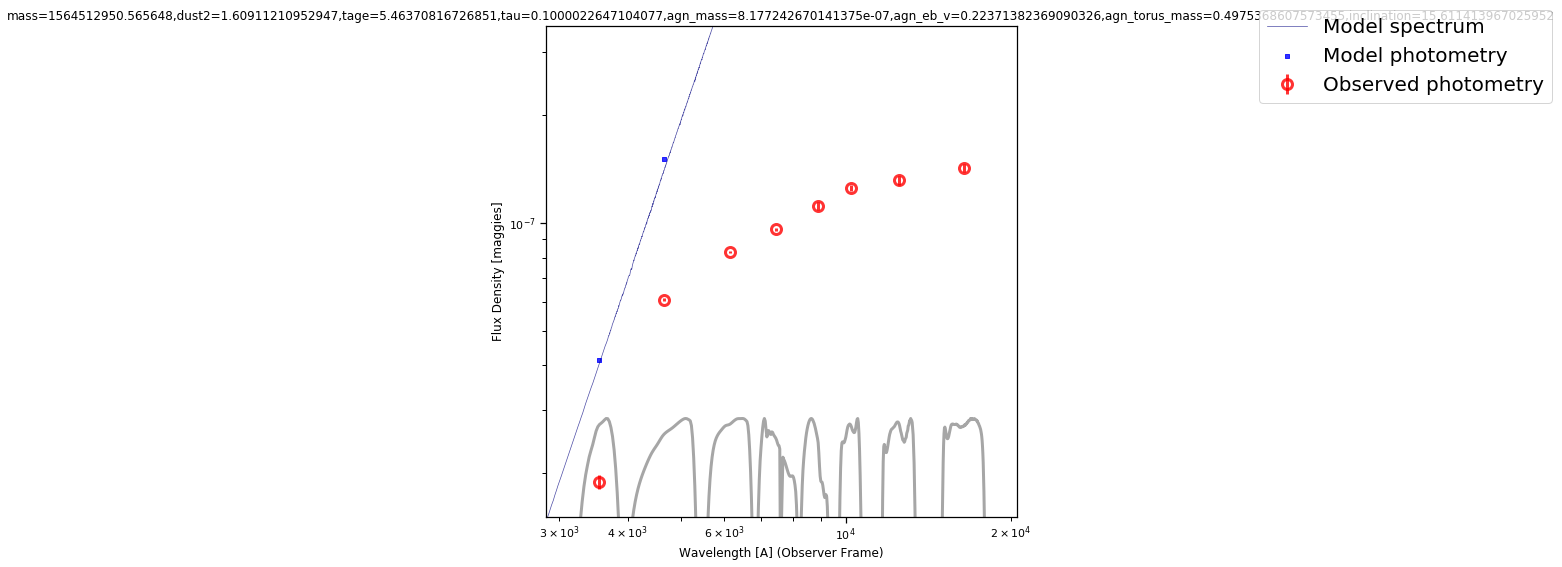

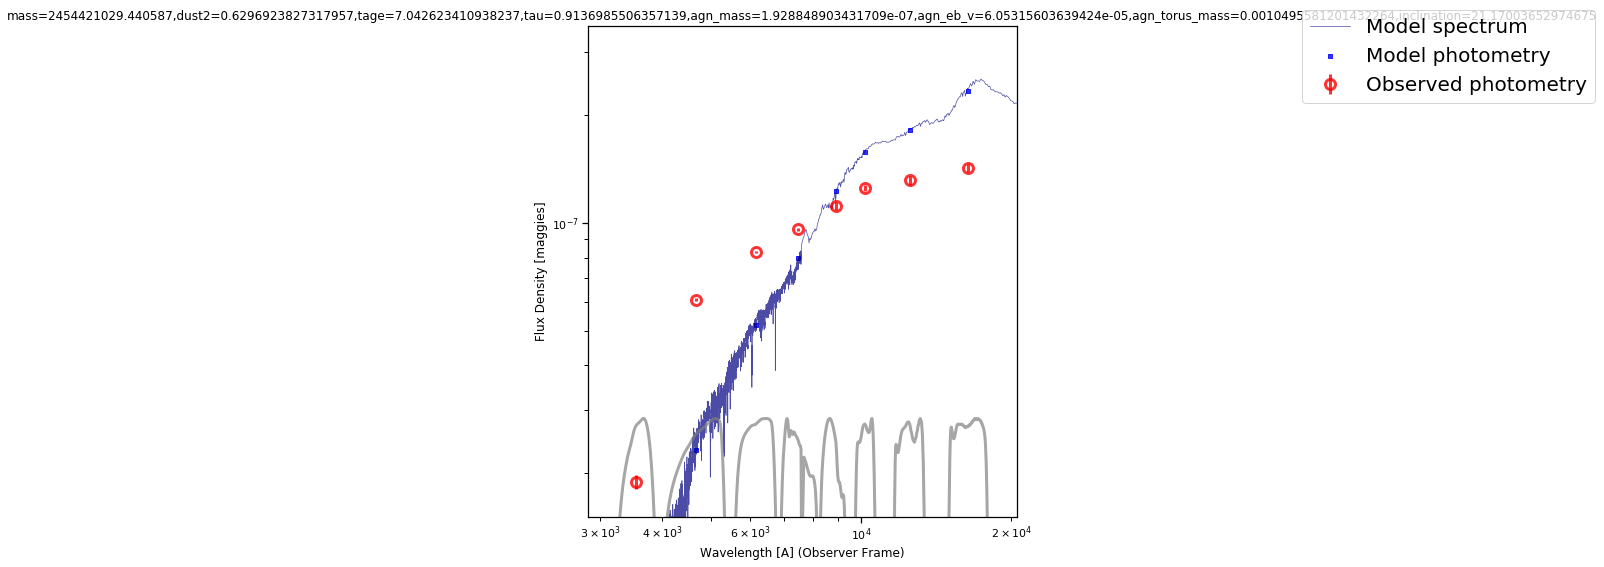

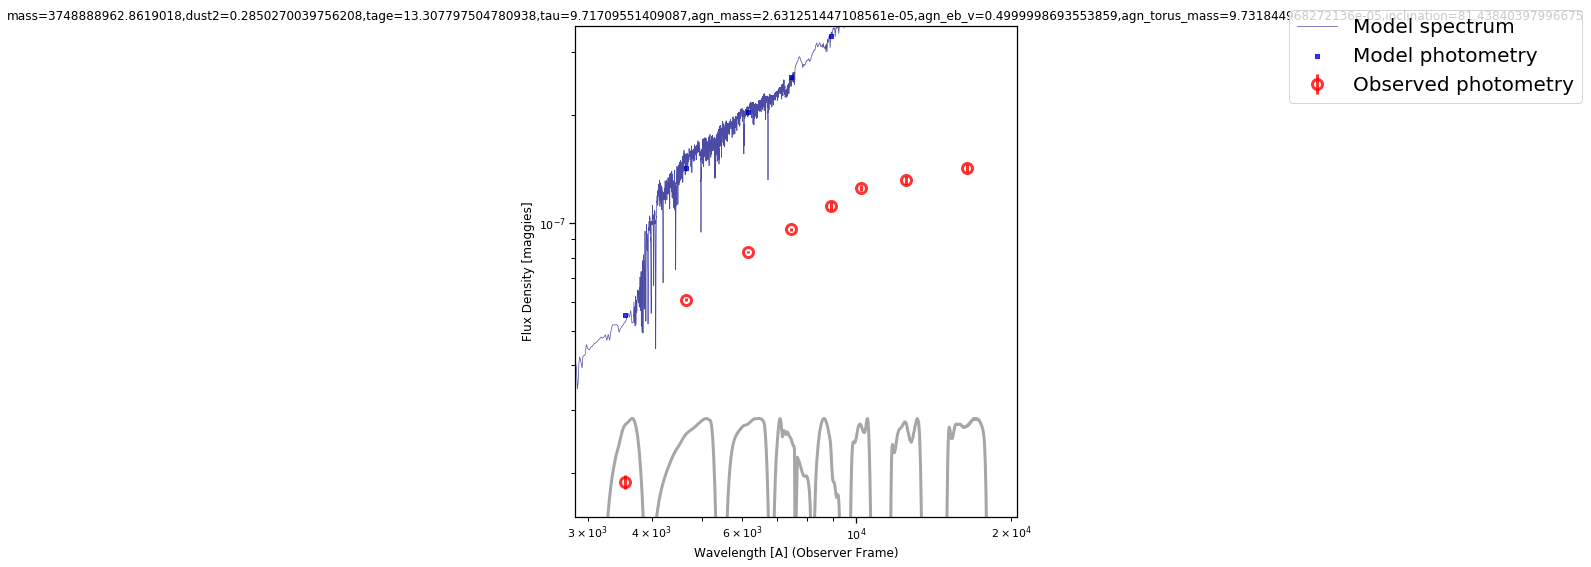

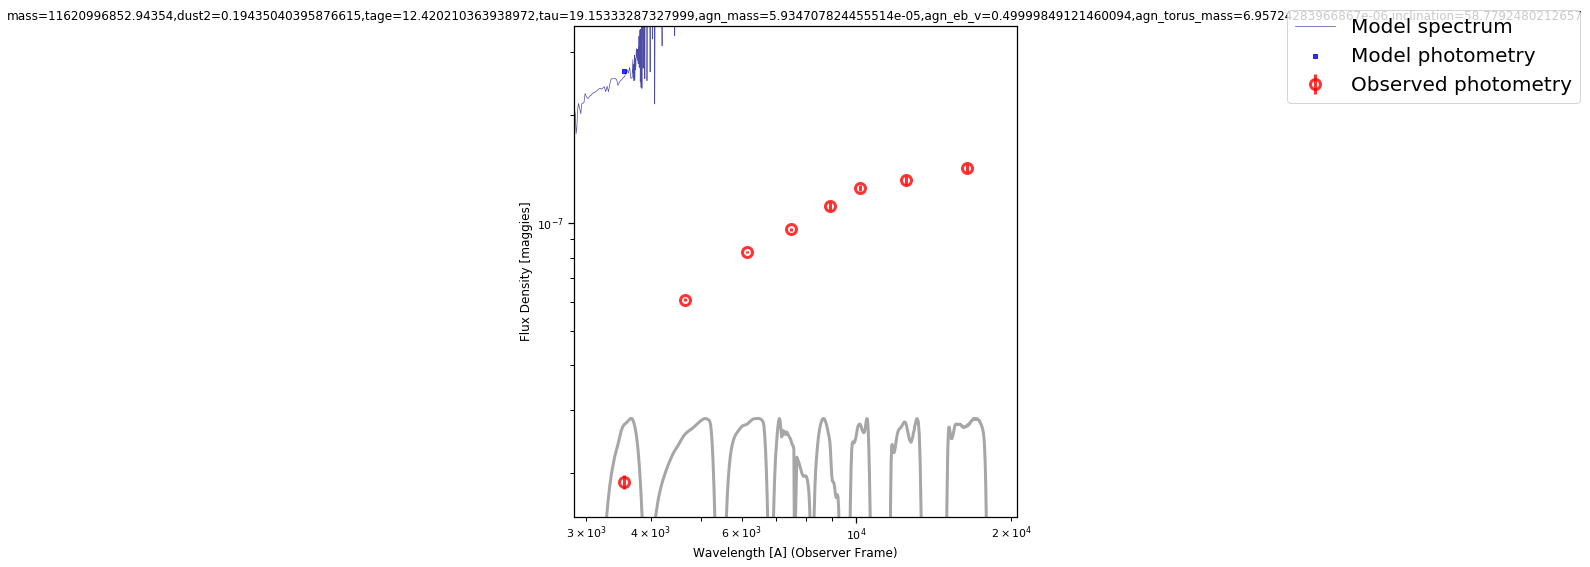

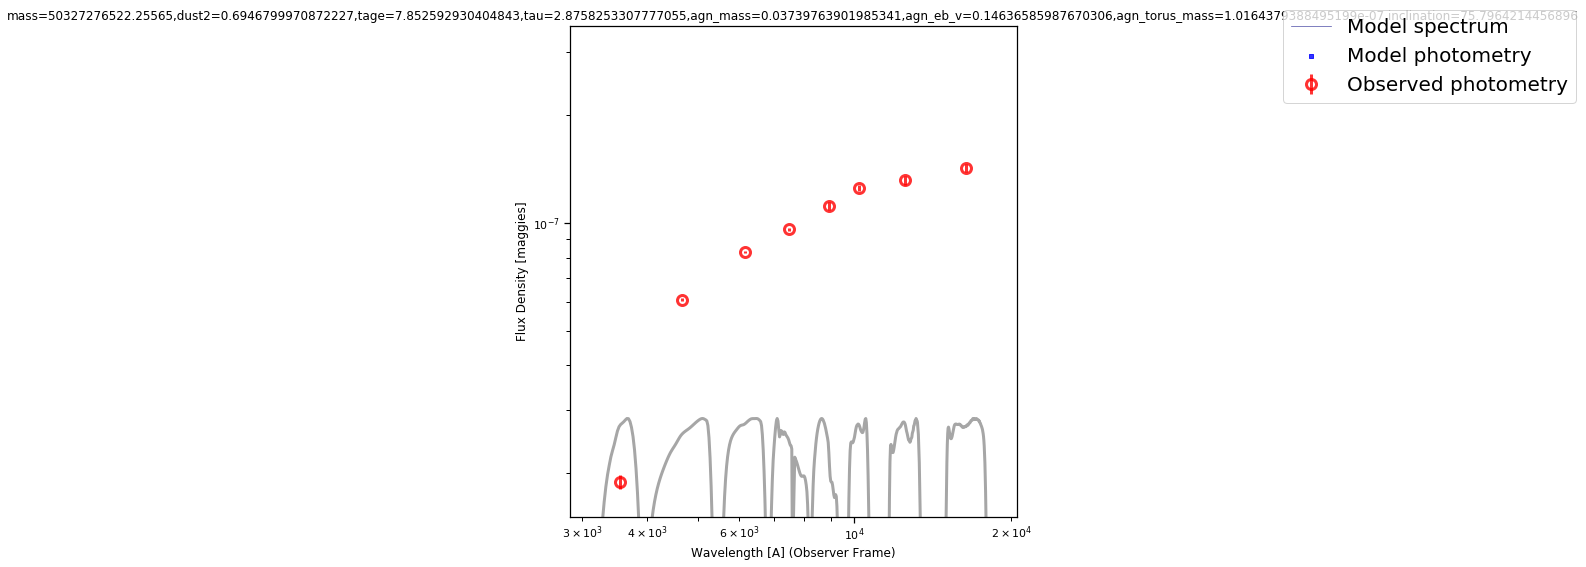

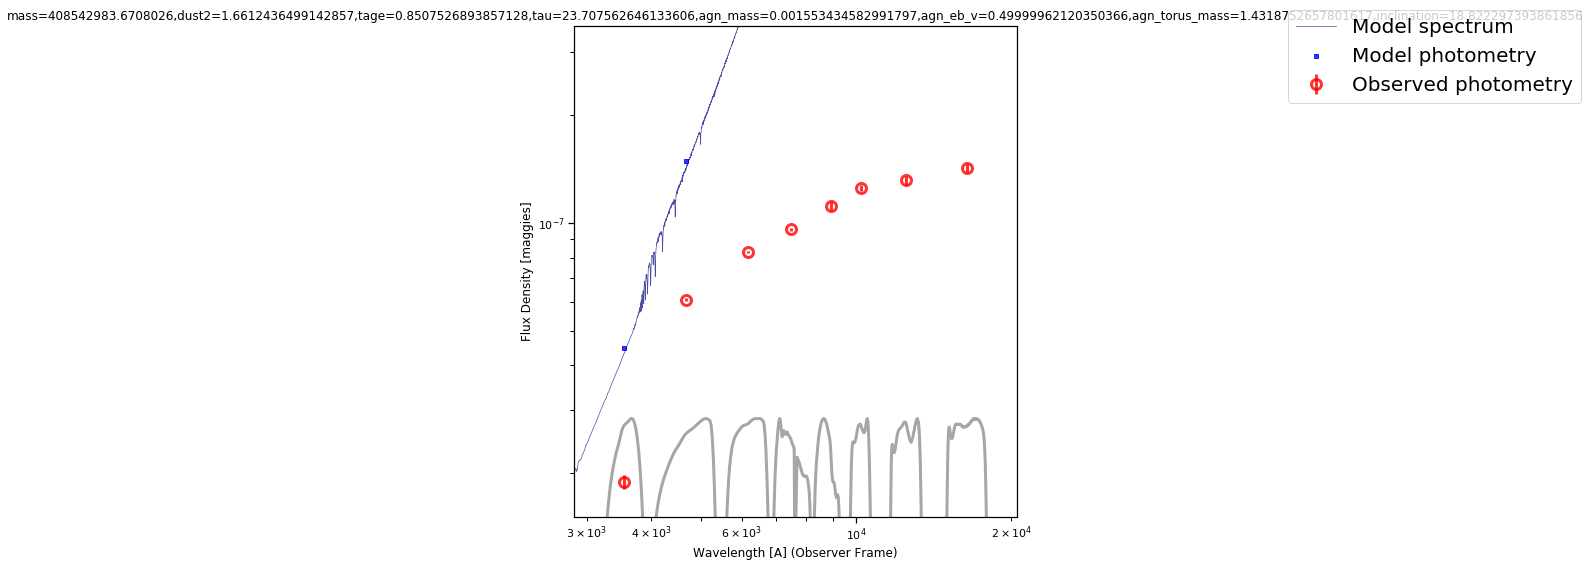

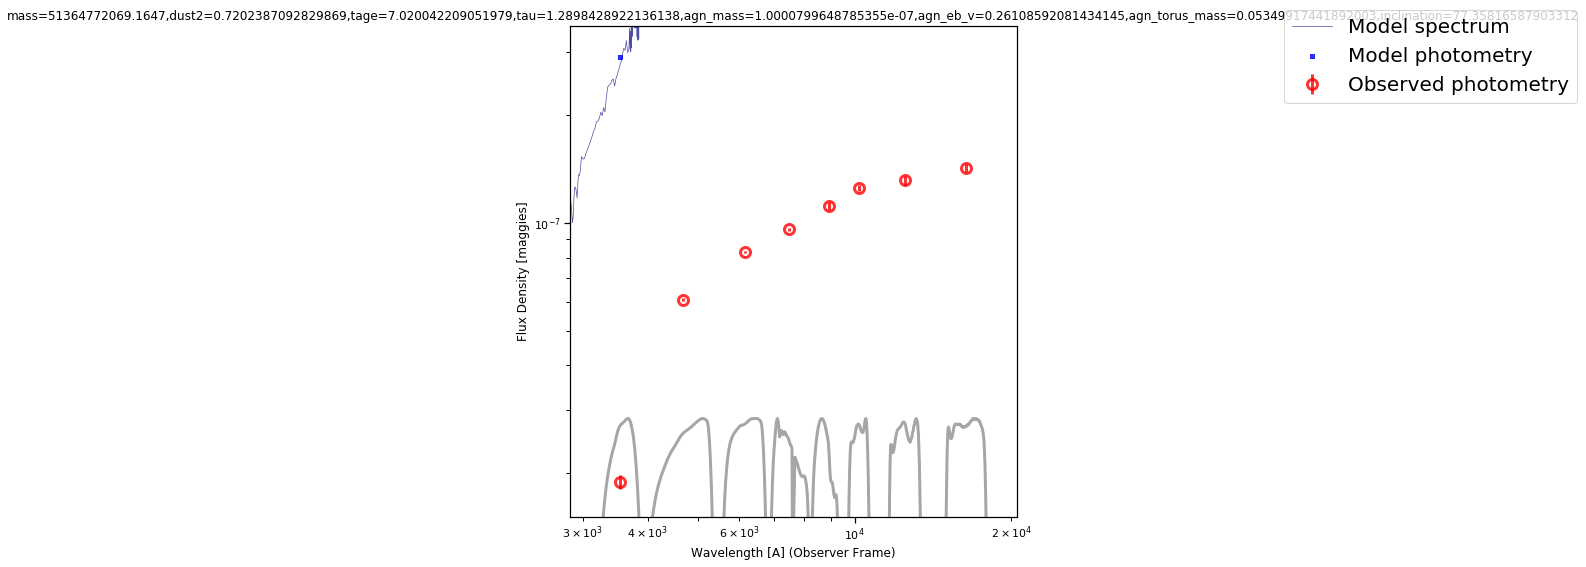

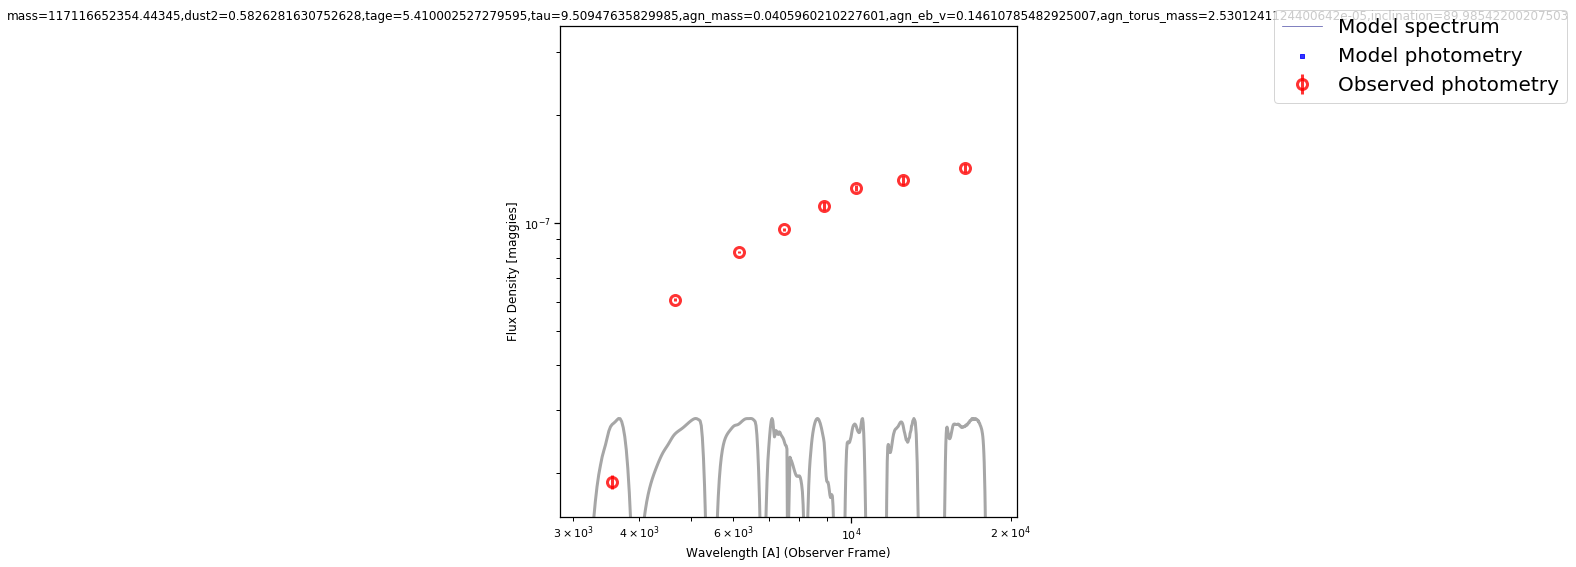

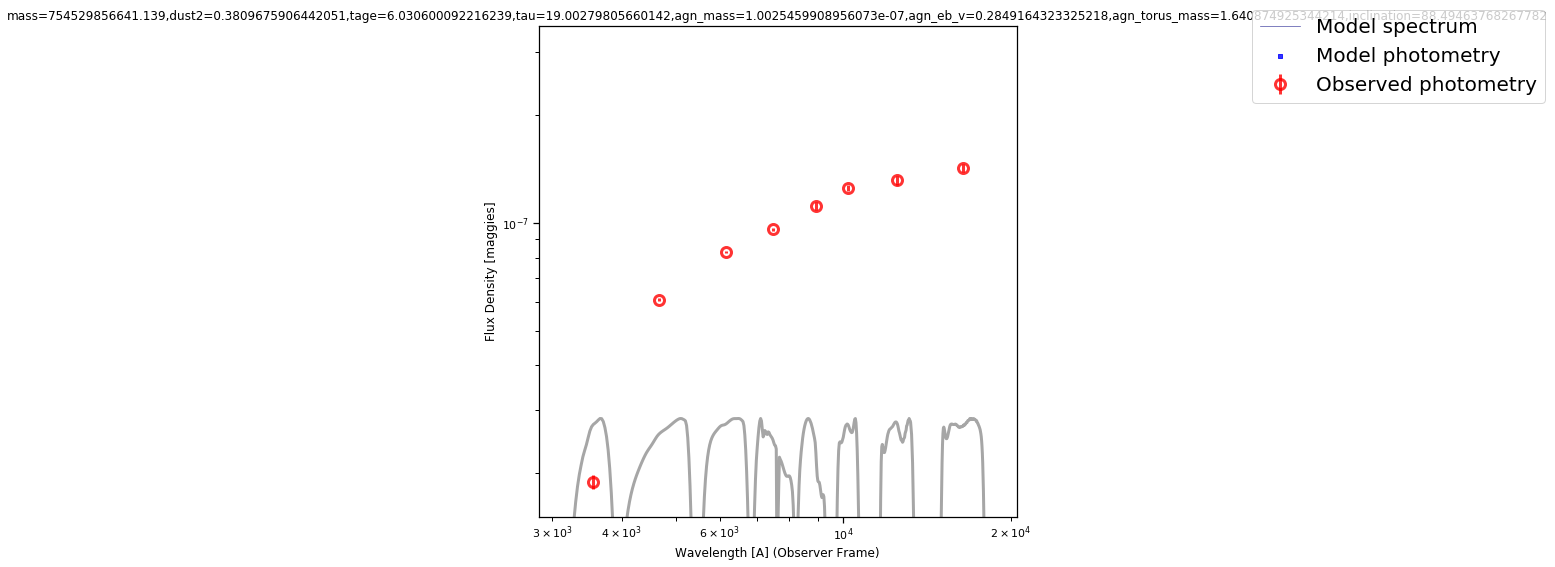

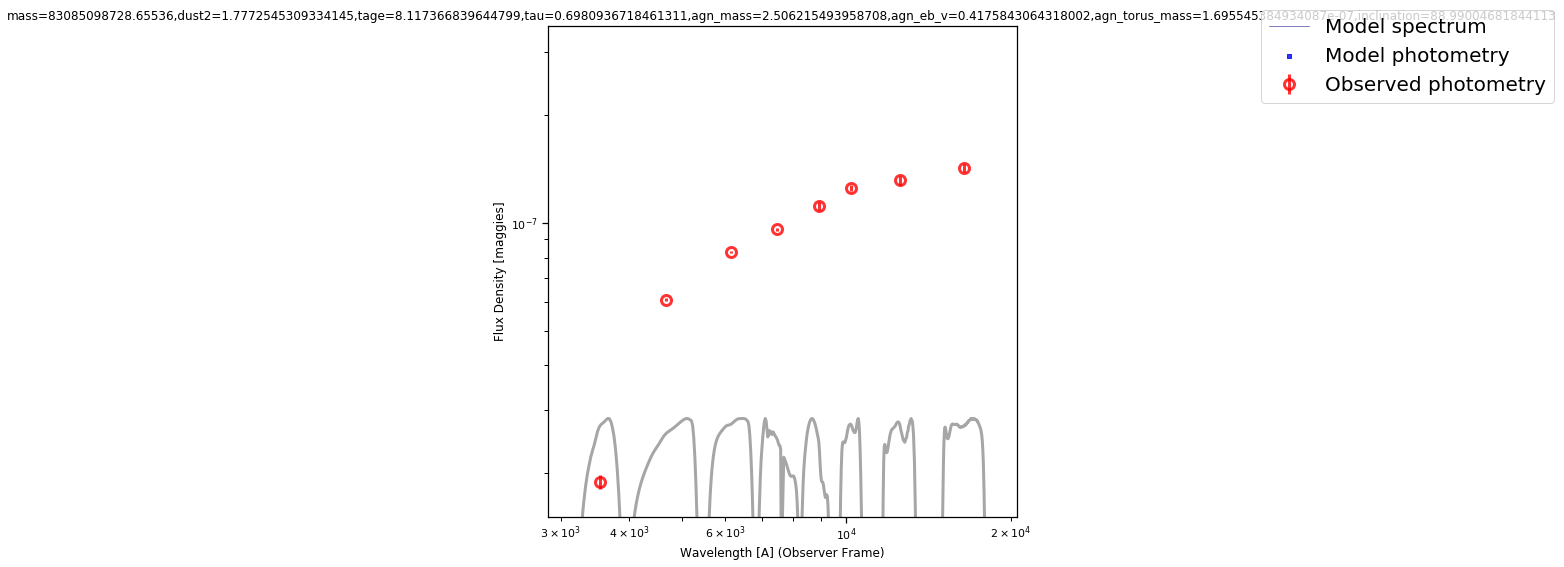

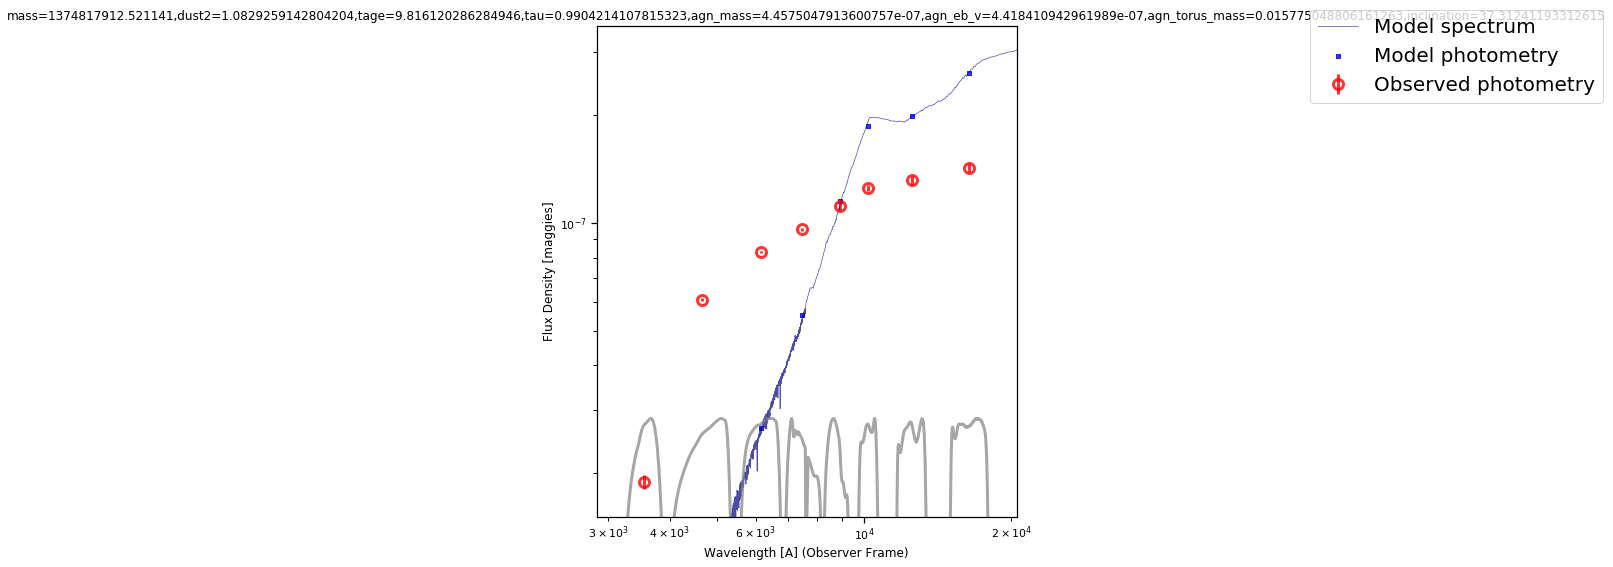

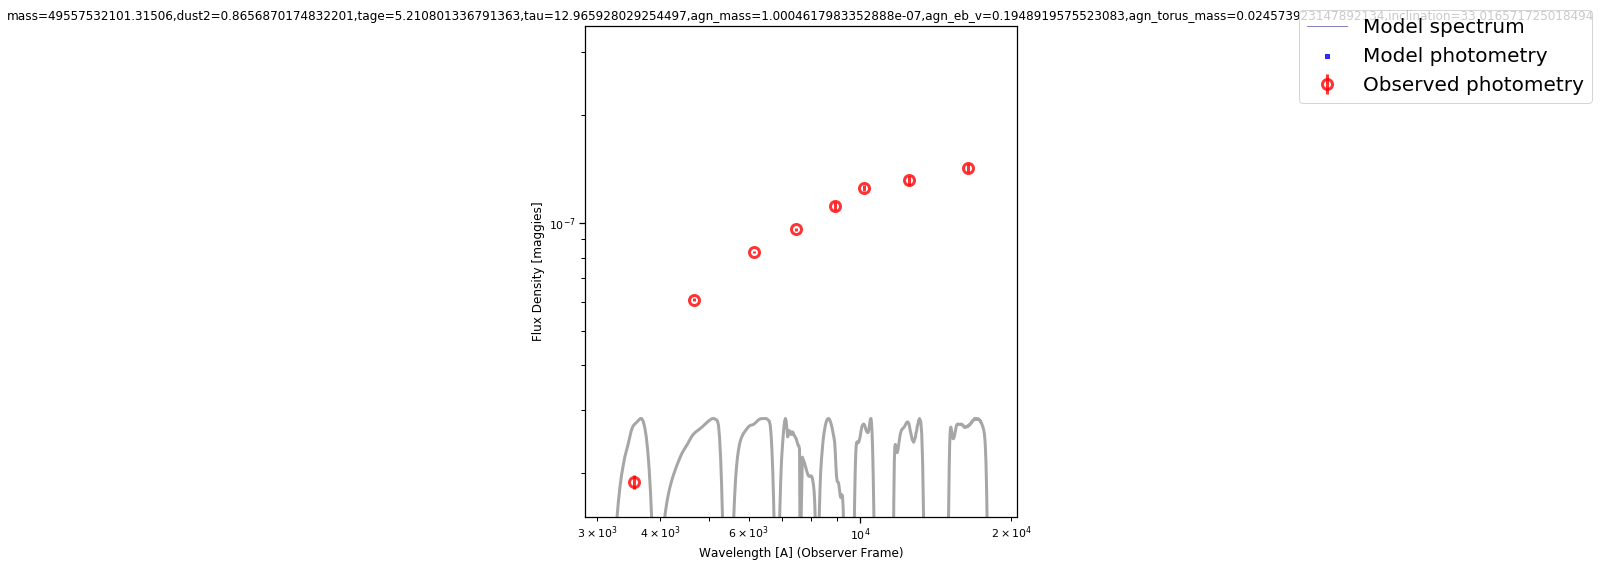

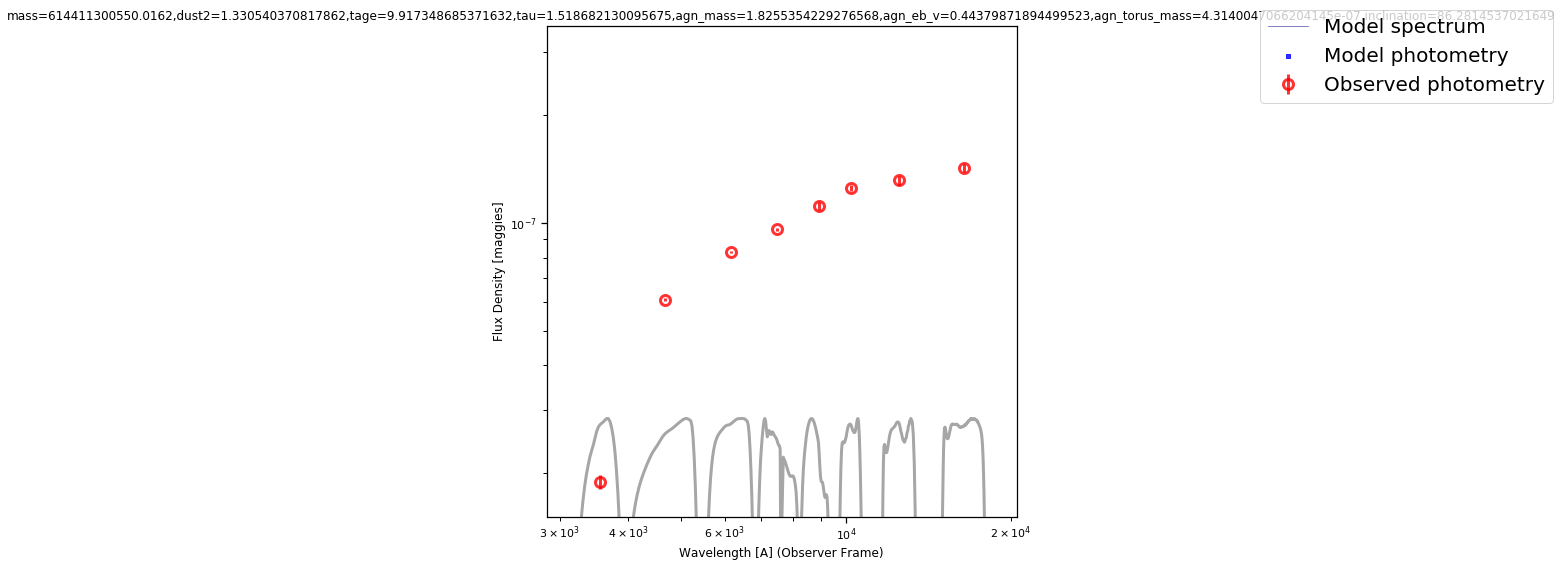

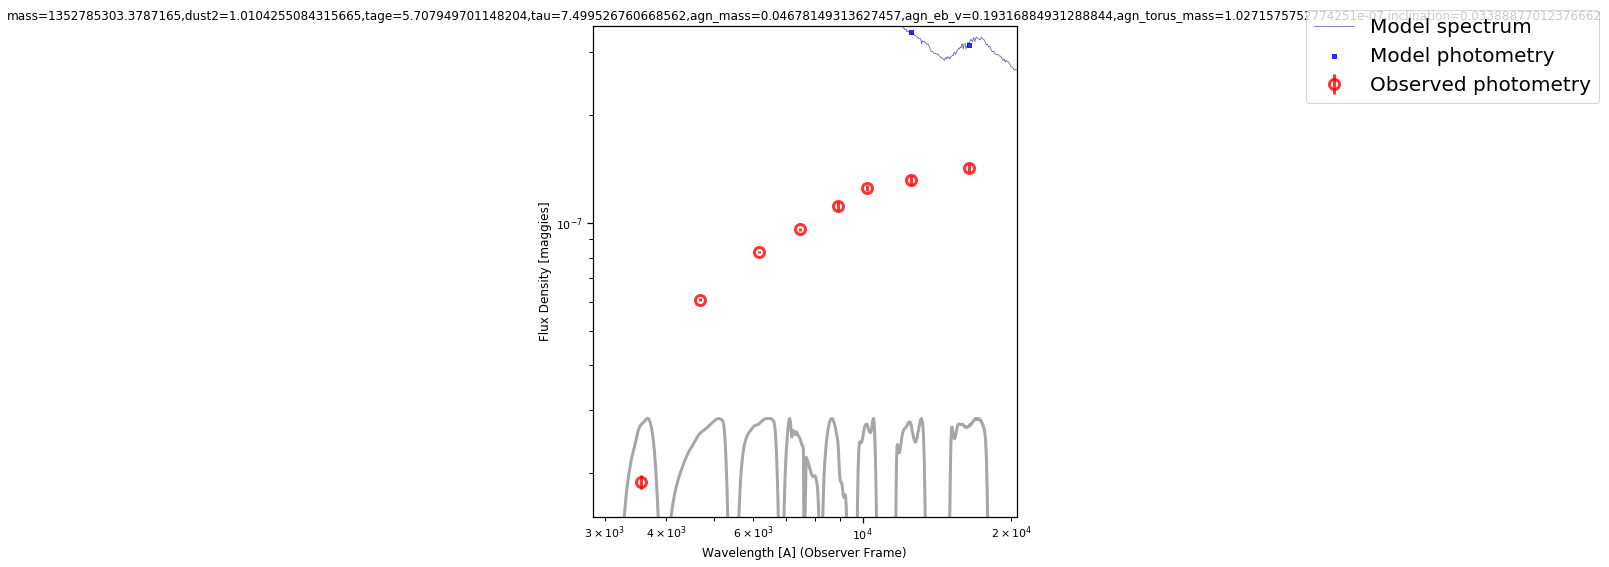

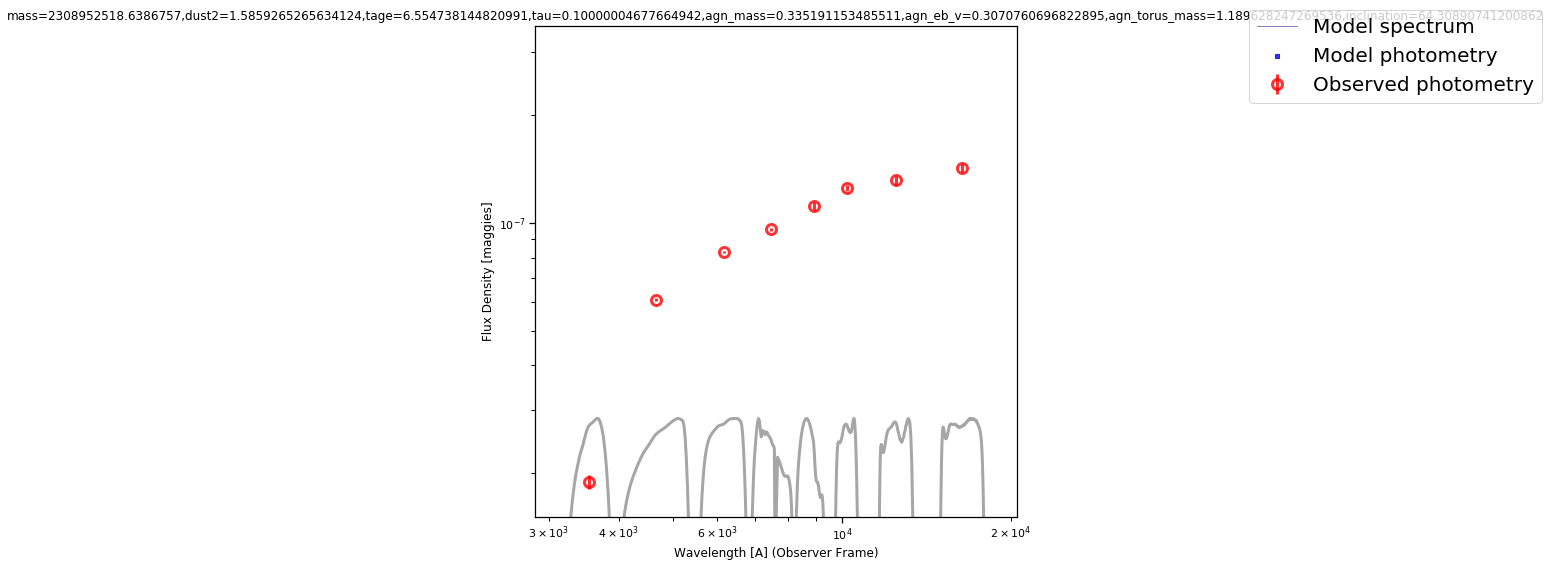

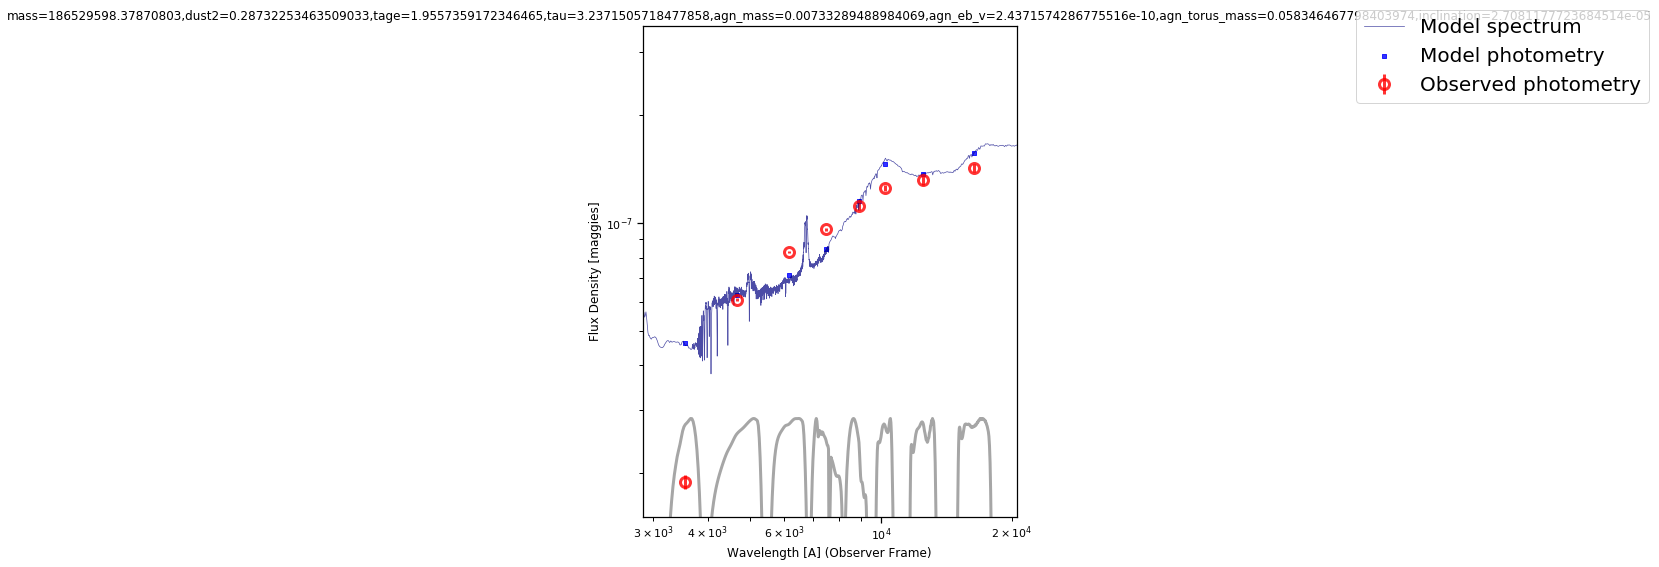

In [91]:
for n in range(len(results)):
    visualise.visualise_obs_and_model(obs, model, results[n]['x'], sps)
# plt.savefig(os.path.join(save_dir, '{}_ml_estimate.png'.format(name)))
# plt.clf()

(array([2., 2., 0., 0., 1., 0., 2., 1., 2., 0., 0., 0., 1., 2., 2., 2., 0.,
        1., 3., 1., 1., 2., 0., 3., 1., 2., 0., 1., 0., 0., 0., 2., 0., 0.,
        0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 2.34537594,  2.62494045,  2.90450497,  3.18406948,  3.46363399,
         3.74319851,  4.02276302,  4.30232754,  4.58189205,  4.86145656,
         5.14102108,  5.42058559,  5.70015011,  5.97971462,  6.25927913,
         6.53884365,  6.81840816,  7.09797268,  7.37753719,  7.6571017 ,
         7.93666622,  8.21623073,  8.49579525,  8.77535976,  9.05492427,
         9.33448879,  9.6140533 ,  9.89361782, 10.17318233, 10.45274684,
        10.73231136, 11.01187587, 11.29144038, 11.5710049 , 11.85056941,
        12.13013393, 12.40969844, 12.68926295, 12.96882747, 13.24839198,
        13.5279565 , 13.80752101, 14.08708552, 14.36665004, 14.64621455,
        14.92577907, 15.20534358, 15.48490809, 15.76447261, 16.04403712,
        16.32360164]),
 <a list of 50 Patch 

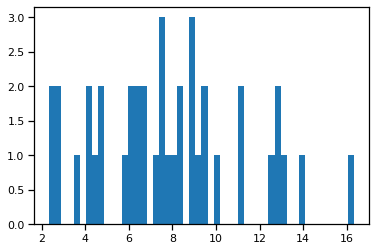

In [93]:
costs = [r.cost for r in results]
plt.hist(np.log10(costs), bins=50)
# plt.clf()